## Import Library

In [1]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
from datetime import datetime, timedelta
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from datetime import timedelta, date
# from toolbox.cartopy_tools import common_features, pc  # <-- This is from https://github.com/blaylockbk/Carpenter_Workshop
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from goes2go.data import goes_nearesttime, goes_latest
from goes2go.tools import abi_crs, field_of_view
from osgeo import gdal
from pyproj import Proj, Transformer, CRS, transform
from scipy.interpolate import RegularGridInterpolator as rgi
import h5py
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'toolbox'

In [107]:
hgtlvs = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400
    , 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000
    , 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 11000, 12000, 13000
    , 14000, 15000, 16000, 17000, 18000, 19000, 20000, 25000, 30000, 35000, 40000, 45000]
    
# Function that create an interpretor with an assigned parameter
def make_interpretor(ds, para=None):
    x = ds.x.values
    y = ds.y.values
    z = ds.z.values
    if not para:
        data = ds.transpose('x', 'y', 'z')
    else:
        data = ds.variables[para].transpose('x', 'y', 'z')
    interpolator = rgi(points=(x, y, z), values=data.values, method='linear', bounds_error=False)
    return interpolator

# Import function
def get_rowcol(Raster, left, bottom, right, top, xs, ys):
    with rasterio.open(Raster) as src:
        window = from_bounds(left, bottom, right, top, src.transform)
        rows, cols = rasterio.transform.rowcol(src.window_transform(window), xs, ys)
    return rows, cols
# Convert radian to cm or m
def convert_rad(data, lamda):
    result = (data * lamda) / (4 * np.pi)
    return result

# Extract value from raster and their lat/lon grid of the bounding area
def focus_bound(Raster, left, bottom, right, top):
    from rasterio.windows import Window
    from rasterio.windows import from_bounds
    with rasterio.open(Raster) as src:
        window = from_bounds(left, bottom, right, top, src.transform)
        w = src.read(1, window=window)
        aff = src.window_transform(window=window)
        X = [i * aff[0] + aff[2] for i in range(w.shape[1])]
        Y = [i * aff[4] + aff[5] for i in range(w.shape[0])]
        X, Y = np.meshgrid(X, Y)
        grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return w, grid
    
def Resamp_rasterio(fn: str, left, bottom, right, top, ref):
    with rasterio.open(fn) as src:
        r_height, r_width = ref.shape
        window = from_bounds(left, bottom, right, top, src.transform)
        data = src.read(out_shape=(
            src.count,
            int(r_height),
            int(r_width)),
            resampling=Resampling.nearest, window=window)
        X = np.linspace(left, right, r_width)
        Y = np.linspace(top, bottom, r_height)
        X, Y = np.meshgrid(X, Y)
        grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
        return data[0], grid
    
def convert_rad_degree(ds):
    # GOES-R projection info and retrieving relevant constants
    proj_info = ds.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # Data info
    lat_rad_1d = ds.variables['x'][:]
    lon_rad_1d = ds.variables['y'][:]

    # close file when finished
    # g16nc.close()
    # g16nc = None

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    
    r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    return lon, lat

def extract_param_training(start_date:str, end_date:str, time:str, wm_path, dem_path, file_name, ref:str=None, batchsize=500):
    # start_date, end_date: Require string and are refering to the date range you are trying to extract. Keep the date in the format of YYYY-MM-DD (e.g. '2019-10-24')
    # time: Require string and are related to the specific UTC time HH:MM:SS (e.g.'11:00:00')
    # wm_path: The file path to all the saved weather models
    # dem_path: The file path to saved DEM
    # file name: The name to be given to the csv file will be generated.
    # ref: Require string, used when either coverage of weather model or DEM is smaller than one another. 
    def daterange(date1, date2):
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)
    dates = daterange(datetime.strptime(start_date, '%Y-%m-%d'),datetime.strptime(end_date, '%Y-%m-%d'))

    for i, day in enumerate(dates):
        print(day.strftime('%Y-%m-%d'))
        wm_path_ = glob.glob(wm_path+ 'ERA-5_{date}_T{time}*[A-Z].nc'.format(date=day.strftime('%Y_%m_%d'), time=time.replace(':', '_')))
        print(wm_path_)
        wm = xr.load_dataset(" ".join(wm_path_))
        if ref == 'DEM':
            with rasterio.open(dem_path) as src:
                lon_min, lon_max, lat_min, lat_max = src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top
        else:
            lon_min, lon_max, lat_min, lat_max = wm.x.values.min(), wm.x.values.max(), wm.y.values.min(), wm.y.values.max()
        print(lon_min, lon_max, lat_min, lat_max)
        # Get TPW of the day and by the hour
        try:
            tpw = goes_nearesttime(day.strftime('%Y-%m-%d') + ' ' + time, product='ABI-L2-TPW', domain='C' )
        except ValueError:
            continue
        lon, lat = convert_rad_degree(tpw)
        print(np.nanmin(lon), np.nanmax(lon),np.nanmax(lat), np.nanmin(lat))
        df = pd.DataFrame(np.hstack((lon.reshape(-1,1), lat.reshape(-1,1), (tpw.TPW*0.62).values.ravel().reshape(-1,1)))).dropna()
        df = df[(df[0]<lon_max) & (df[0]>lon_min) & (df[1]<lat_max) & (df[1]>lat_min)]
        sort_lat  = np.linspace(lat_min, lat_max, lat.shape[0])
        sort_lon = np.linspace(lon_min, lon_max, lon.shape[-1])
        if i == 0:
            with rasterio.open(dem_path) as src:
                rows, cols = rasterio.transform.rowcol(src.transform, df[0].values, df[1].values)
                hgt_m = src.read(1)[rows, cols]
                # hgt_m[np.isnan(hgt_m)] = 0.0
        else:
            pass
        
         # xarray interp function can not perform on non regular grid coordinates.
        # The only option of interp with given lat lon to create a arbitary grid in batches then extract the diagonal of the data.
        wm_param = []
        batchsize = batchsize
        for iter in range(0, len(df), batchsize):
            x = df[0].iloc[iter:iter+batchsize]
            y = df[1].iloc[iter:iter+batchsize]
            # print(x, y)
            p = wm.p.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            t = wm.t.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            e = wm.e.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            wm_param.append(np.hstack((p,t,e)))
        wm_param = np.vstack(wm_param)
        acq_date = np.array([day.strftime('%Y-%m-%d')] * int(len(df))).reshape(-1, 1)
        df = pd.concat((pd.DataFrame(acq_date).reset_index(drop=True), df.reset_index(drop=True), pd.DataFrame(hgt_m.reshape(-1,1)).reset_index(drop=True), pd.DataFrame(wm_param).reset_index(drop=True)),axis=1)

        if i == 0:
            df.columns = ['Date', 'Lon', 'Lat', 'PWV', 'Hgt_m'] + ['P_' + str(i) for i in range(len(hgtlvs))] + ['T_' + str(i) for i in range(len(hgtlvs))] +['e_' + str(i) for i in range(len(hgtlvs))]
            df.to_csv(file_name + '_PTE_PWV.csv', index=False)
        else:
            df.to_csv(file_name + '_PTE_PWV.csv', index=False, mode='a', header=False)
        print('Finished')

## Interferogram and LAT LON reading

In [5]:
radar_file = h5py.File('TPW_InSAR/Haiti/geo_geometryRadar.h5','r')

lat = radar_file['latitude'][()]
lon = radar_file['longitude'][()]

print(lat.shape, lon.shape)
print(np.nanmax(lat), np.nanmin(lat))
print(np.nanmax(lon), np.nanmin(lon))

(9260, 7555) (9260, 7555)
20.734665 17.810408
-72.004036 -74.921455


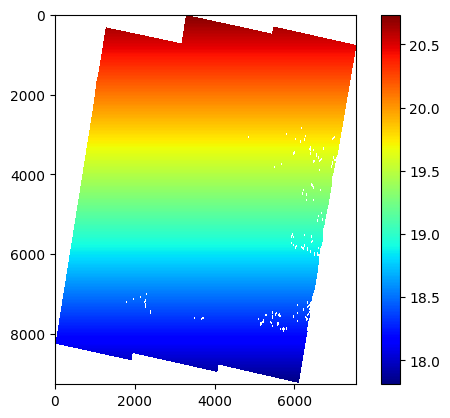

In [61]:
plt.imshow(lat, cmap='jet')
plt.colorbar()
plt.show()

In [36]:
def find_loc(latitude, longitude):
    yloc = np.bincount(np.where(lat == latitude)[0]).argmax()
    xloc = np.bincount(np.where(lon == longitude)[1]).argmax()
    
    print('lat:'+ str(yloc)+ ', lon:'+ str(xloc))

In [157]:
with h5py.File('TPW_InSAR/Haiti/wm.h5', "r") as f:
    mask = f['mask'][()]

In [141]:
with rasterio.open('TPW_InSAR/Haiti/Angle/geom_reference/lat.rdr') as f:
    LAT = f.read(1)
    LAT[LAT==0.0] =  np.nan
with rasterio.open('TPW_InSAR/Haiti/Angle/geom_reference/lon.rdr') as f:
    LON = f.read(1)
    LON[LON==0.0] =  np.nan
# LON[~mask] = np.nan
# LAT[~mask] = np.nan
print(np.nanmax(LON), np.nanmin(LON))
print(np.nanmax(LAT), np.nanmin(LAT))

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


-72.0040393910068 -74.92145541095383
20.734664280607287 17.81040857365188


In [37]:
find_loc(18.8, -74.6), find_loc(18, -72.1)

lat:6126, lon:832
lat:8659, lon:7305


(None, None)

In [158]:
dataset = rasterio.open('TPW_InSAR/Haiti/20220307_20220319/filt_fine.unw')
ifg = dataset.read(2)
ifg[ifg==0] = np.nan
# ifg = np.absolute(ifg)
ifg[~mask] = np.nan
# ifg = (ifg * 5.6) / (4*np.pi)

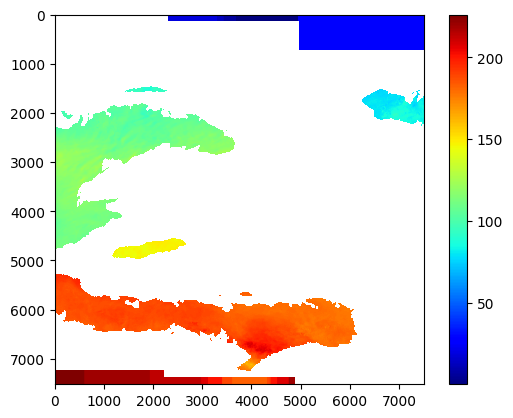

In [6]:
plt.imshow(ifg, cmap='jet')
plt.colorbar()
plt.show()

In [67]:
ifg[5000:7100, 0:7000].shape

(2100, 7000)

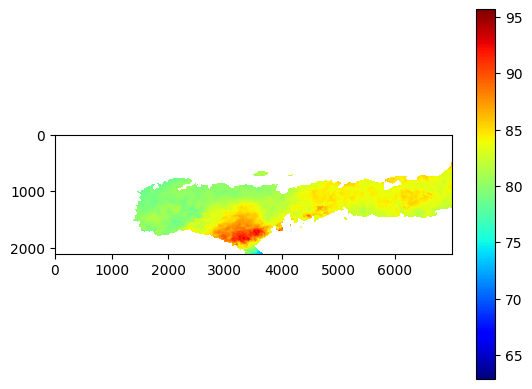

In [64]:
plt.imshow(np.fliplr(ifg)[5000:7100, 0:7000], cmap='jet')
plt.colorbar()
plt.show()

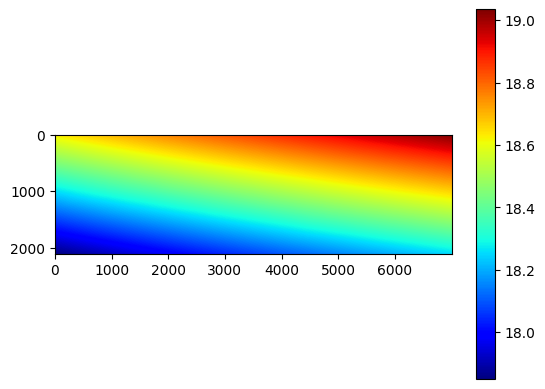

In [69]:
plt.imshow(LAT[5000:7100, 0:7000], cmap='jet')
plt.colorbar()
plt.show()

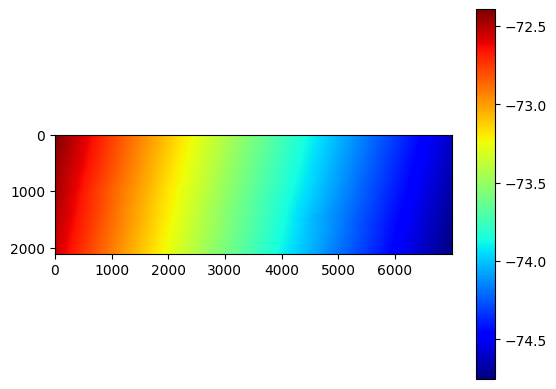

In [70]:
plt.imshow(LON[5000:7100, 0:7000], cmap='jet')
plt.colorbar()
plt.show()

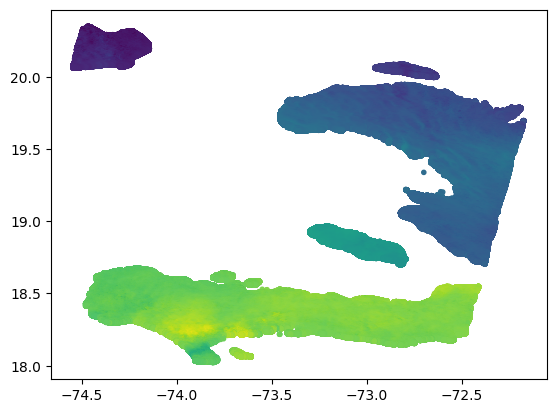

In [54]:
plt.scatter(LON.ravel(), LAT.ravel(), c=ifg.ravel(), marker='.')

In [38]:
N_ifg = ifg[1000:5000]
S_ifg = ifg[5000:7200]

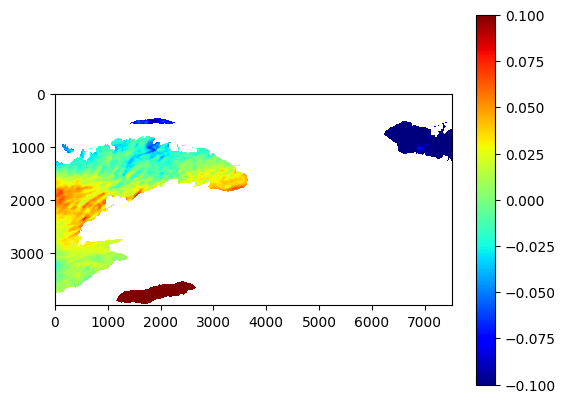

In [39]:
plt.imshow(N_ifg - N_ifg[1500, 1000], vmin=-0.10, vmax=0.10, cmap='jet')
plt.colorbar()
plt.show()

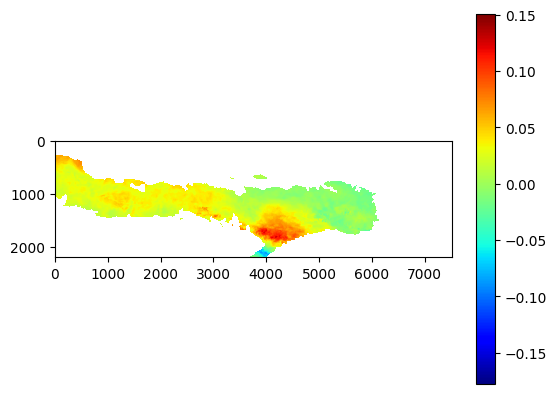

In [40]:
plt.imshow(S_ifg - S_ifg[1000, 4000], cmap='jet')
plt.colorbar()
plt.show()

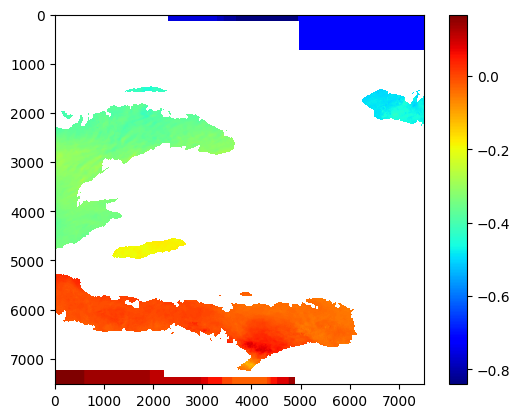

In [29]:
plt.imshow(ifg, cmap='jet')
plt.colorbar()
plt.show()

# Download GOES data by date and time

GOES data are downloaded from AWS S3 through the package of goes2go. By selecting the date time and products. It will download directly on file and be able to reopen them when needed. More information on https://github.com/blaylockbk/goes2go 

In [136]:
ds1 = goes_nearesttime('2022-03-07 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2022-03-19 10:47', product='ABI-L2-TPW', domain='C')

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/066/10/OR_ABI-L2-TPWC-M6_G16_s20220661046170_e20220661048543_c20220661050590.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


The fixed grid is rectified to an ellipsoid defined by the Geodetic Reference
System 1980 (GRS80) earth model.

In [137]:
def radian2degree(ds):
    # Satellite height
    sat_h = ds.goes_imager_projection.perspective_point_height

    # Satellite longitude
    sat_lon = ds.goes_imager_projection.longitude_of_projection_origin
    sat_lat = ds.goes_imager_projection.latitude_of_projection_origin

    # Satellite sweep
    sat_sweep = ds.goes_imager_projection.sweep_angle_axis

    # The projection x and y coordinates equals
    # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
    X = ds.x * sat_h
    Y = ds.y * sat_h
    # map object with pyproj
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
    # Convert map points to latitude and longitude with the magic provided by Pyproj
    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)
    return lons, lats

All GOES data came in as .nc file and they are all georefernced to the geostationary coordianate. (It's not the most easy one to get to the very places that you want.) By converting to a projected coordinate as Lat, Lon. It's much easier to obtain the right position that you needed. After reprojection, it's no longer a regular gridded system. 

In [138]:
satellite = 'goes16'
domain = 'C'
def data_addLatLon(ds1, satellite, domain):
    lons, lats = radian2degree(ds1)
    lats[np.isinf(lats)] = np.nan
    lons[np.isinf(lons)] = np.nan

    ds = xr.Dataset(dict(latitude=(('y', 'x'), lats), 
                        longitude=(('y', 'x'), lons),
                        TPW = (('y', 'x'), ds1.TPW.values)))

    ds.latitude.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
    ds.longitude.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')
    ds.TPW.attrs = dict(standard_name='TPW', long_name='Total Percipitable Water Vapor', units='mm')

    ds.coords['latitude'] = ds.latitude
    ds.coords['longitude'] = ds.longitude
    ds['TPW'] = ds.TPW

    if domain == 'C':
        D = 'CONUS'
    elif domain == 'F':
        D = 'Full-Disk'

    ds.attrs['name'] = f'lat/lon grid for {satellite} {D}'
    ds.attrs['author'] = 'Brian K. Blaylock'
    ds.attrs['created'] = f"{datetime.now():%Y-%m-%d %H:%M}"
    ds.attrs['history'] = ''

    ds = ds.where(~np.isinf(ds.latitude))
    ds = ds.where(~np.isinf(ds.longitude))

    # name = f'./latlon_{satellite}-{domain}.nc'
    # ds.to_netcdf(name)
    return ds

In [139]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

/tmp/ipykernel_1856/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


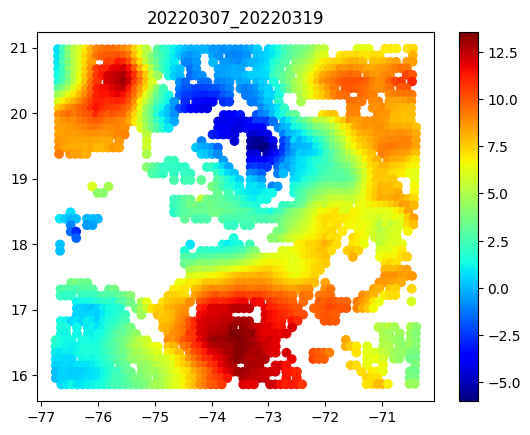

In [252]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < LON[5000:7100, 0:7000].max()+2) & (DS1.lon > LON[5000:7100, 0:7000].min()-2) & (DS1.lat > LAT[5000:7100, 0:7000].min()-2) & (DS1.lat < LAT[5000:7100, 0:7000].max()+2))
tpw2 = DS2.where((DS2.lon < LON[5000:7100, 0:7000].max()+2) & (DS2.lon > LON[5000:7100, 0:7000].min()-2) & (DS2.lat > LAT[5000:7100, 0:7000].min()-2) & (DS2.lat < LAT[5000:7100, 0:7000].max()+2))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values), cmap='jet')
plt.title('20220307_20220319')
plt.colorbar()
plt.show()

## Use Kriging to fill nan in GOES-TPW
In GOES-TPW there are many areas do not have data due to the coverage of clouds. In order to fill out the NAN in cloud coverage areas.
Using Ordinary Kriging from pykidge pacakge to input the coordiantes by lat and lon and values to get an varigram model. At this part, the spherical model is selected and used for predicting the empty NAN.

In [253]:
# Import Library
from pykrige.ok import OrdinaryKriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 19.990735287170438
Full Sill: 19.990735287170928
Range: 3.657463825190315
Nugget: 4.897835413497482e-13 



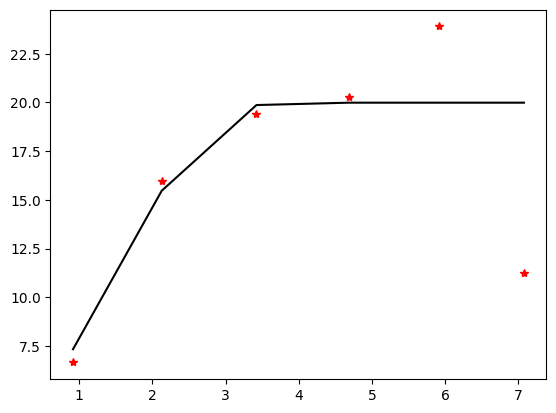

Calculating statistics on variogram model fit...


In [254]:
clean_tpw_1 = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw1.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw_1[0].values
y = clean_tpw_1[1].values
val = clean_tpw_1[2].values
OK_1 = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 46.85374414725779
Full Sill: 50.31915412979255
Range: 6.100616967775053
Nugget: 3.465409982534756 



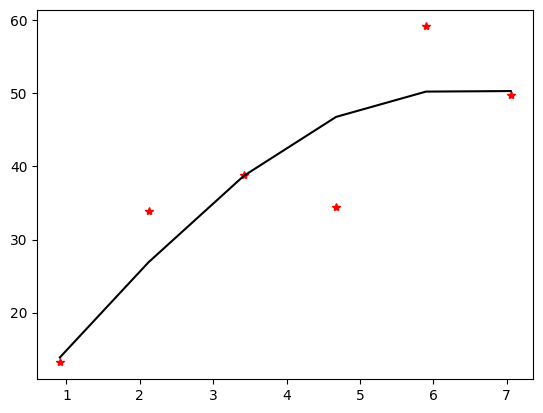

Calculating statistics on variogram model fit...


In [255]:
clean_tpw_2 = pd.DataFrame(np.hstack((tpw2.lon.values.ravel().reshape(-1,1), tpw2.lat.values.ravel().reshape(-1,1), (tpw2.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw_2[0]
y = clean_tpw_2[1]
val = clean_tpw_2[2]
OK_2 = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 10.817264352512048
Full Sill: 18.033215452972684
Range: 7.064959541687244
Nugget: 7.215951100460635 



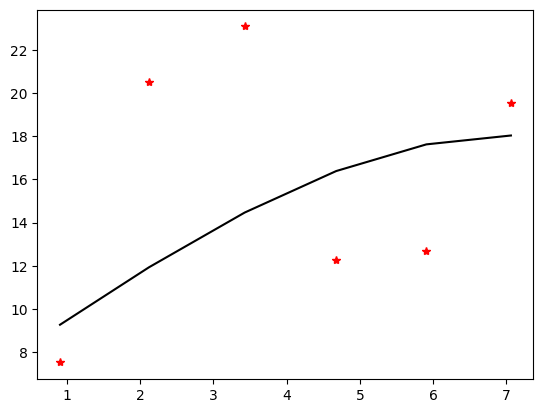

Calculating statistics on variogram model fit...


In [256]:
# Import Library
from pykrige.ok import OrdinaryKriging
clean_tpw = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw1.TPW.values - tpw2.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw[0].values
y = clean_tpw[1].values
val = clean_tpw[2].values
OK = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True)

In [257]:
gridx = np.linspace(LON[5000:7100, 0:7000].min(), LON[5000:7100, 0:7000].max(), 400)
gridy = np.linspace(LAT[5000:7100, 0:7000].min(), LAT[5000:7100, 0:7000].max(), 150)
estimate, ss = OK.execute('grid', gridx, gridy)
estimate1, _ = OK_1.execute('grid', gridx, gridy)
estimate2, _ = OK_2.execute('grid', gridx, gridy)

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [199]:
LON[5000:7100, 0:7000].min(), LON[5000:7100, 0:7000].max()

(-74.7522946484913, -72.39376554527772)

In [200]:
LAT[5000:7100, 0:7000].min(), LAT[5000:7100, 0:7000].max()

(17.85029288455056, 19.03442495456009)

In [258]:
# X = np.linspace(np.nanmin(LON[5000:7100, 0:7000]), np.nanmax(LON[5000:7100, 0:7000]), 7000)
# Y = np.linspace(np.nanmax(LAT[5000:7100, 0:7000]), np.nanmin(LAT[5000:7100, 0:7000]), 2100)
X = LON[5000:7100, 0:7000].ravel()
Y = LAT[5000:7100, 0:7000].ravel()
# X, Y = np.meshgrid(X, Y)
grid = np.stack([Y.ravel(), X.ravel()], axis=-1)

In [259]:
LAT[5000:7100, 0:7000]

array([[18.63260336, 18.63267499, 18.63274661, ..., 19.034328  ,
        19.03437648, 19.03442495],
       [18.63223068, 18.63230231, 18.63237393, ..., 19.03395607,
        19.03400455, 19.03405303],
       [18.63185801, 18.63192964, 18.63200126, ..., 19.03358415,
        19.03363263, 19.0336811 ],
       ...,
       [17.85103833, 17.85111013, 17.85118192, ..., 18.25437138,
        18.25442013, 18.25446888],
       [17.85066561, 17.85073741, 17.8508092 , ..., 18.25399942,
        18.25404817, 18.25409692],
       [17.85029288, 17.85036468, 17.85043648, ..., 18.25362747,
        18.25367622, 18.25372497]])

In [260]:
TPW_interp = rgi(points=(gridy, gridx), values=estimate.data, bounds_error=False)(grid)
TPW_interp = np.flipud(np.fliplr(TPW_interp.reshape((2100,7000))))

In [261]:
TPW_1 = rgi(points=(gridy, gridx), values=estimate1.data, bounds_error=False)(grid)
TPW_1 = np.flipud(np.fliplr(TPW_1.reshape((2100,7000))))
TPW_2 = rgi(points=(gridy, gridx), values=estimate2.data, bounds_error=False)(grid)
TPW_2 = np.flipud(np.fliplr(TPW_2.reshape((2100,7000))))

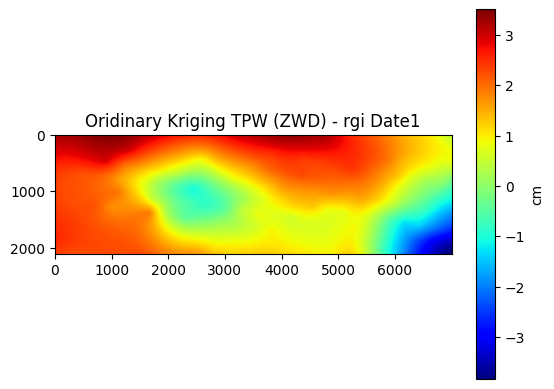

In [262]:
plt.imshow((TPW_1 - TPW_1[1000, 3100])*0.62, cmap='jet')
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi Date1')
plt.show()

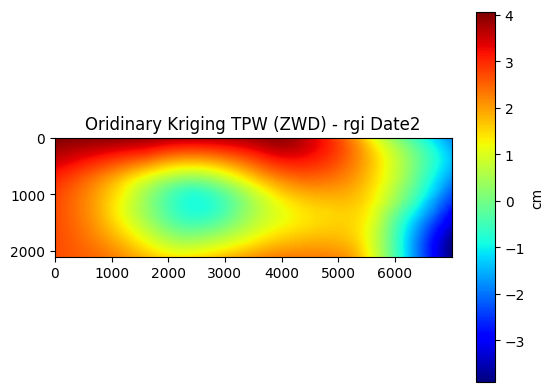

In [263]:
plt.imshow((TPW_2 - TPW_2[1000, 3100])*0.62, cmap='jet')
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi Date2')
plt.show()

In [243]:
area_mask = np.fliplr(ifg)[5000:7100, 0:7000].copy()
# area_mask[~np.isnan(area_mask)] = True
# area_mask[np.isnan(area_mask)] = False

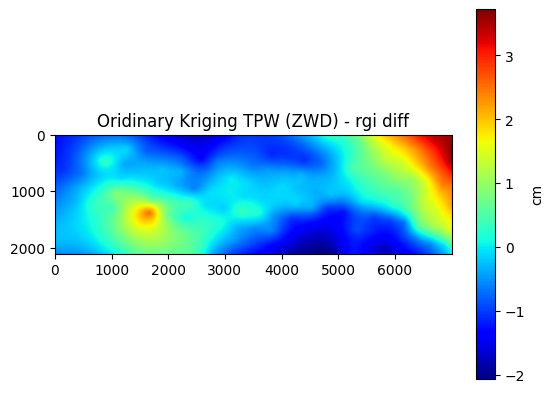

In [264]:
TPW_ = TPW_1 - TPW_2
# TPW_[np.isnan(area_mask)] = np.nan
plt.imshow((TPW_ - TPW_[1000, 3100]), cmap='jet')
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi diff')
plt.show()

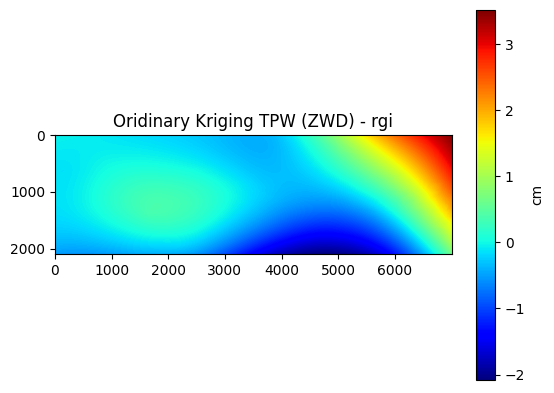

In [265]:
plt.imshow((TPW_interp - TPW_interp[1000, 3100]), cmap='jet')
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi')
plt.show()

In [106]:
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
dataset = rasterio.open(dem)
dataset.transform

Affine(0.0008333333333333334, 0.0, -76.00041666666667,
       0.0, -0.0008333333333333334, 22.000416666666666)

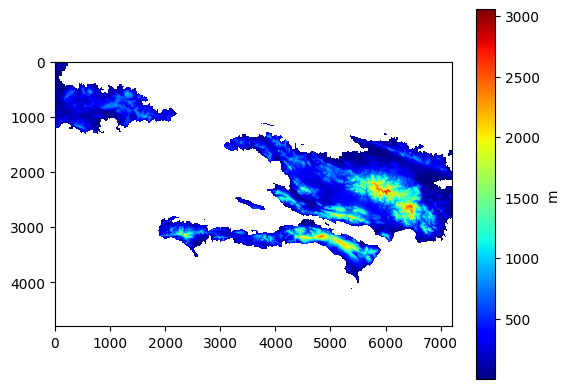

In [100]:
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM, _ = focus_bound(dem, -76, 17, -70, 21)
DEM[DEM<0.0]=np.nan
plt.imshow(DEM, cmap='jet')
plt.colorbar(label='m')
plt.show()

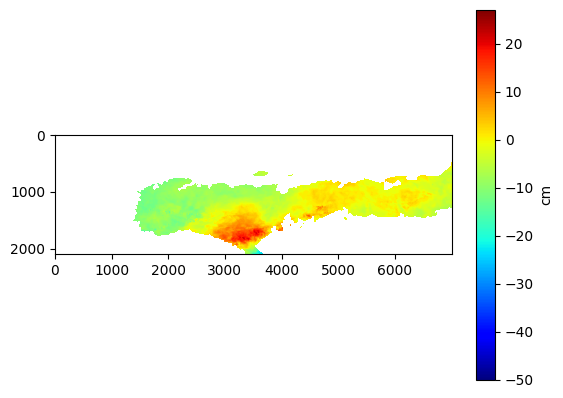

In [266]:
foc_area = np.fliplr(ifg)[5000:7100, 0:7000]
plt.imshow((foc_area - foc_area[1000, 5000]) - (TPW_ - TPW_[1000, 5000]), cmap='jet')
plt.colorbar(label='cm')
plt.show()

In [267]:
# Original ifg std
og_std = np.nanstd((foc_area - foc_area[1000, 5000]))
# TPW corrected ifg std
TPW_corr_std = np.nanstd((foc_area - foc_area[1000, 5000]) - (TPW_ - TPW_[1000, 5000]))
# Percentage chage
per_change = (TPW_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('TPW corrected ifg std: ', TPW_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  5.793025
TPW corrected ifg std:  6.006389522262626
Percentage change:  0.036831276381468554


# RAiDER correction

In [282]:
# Load weather model
WM1 = xr.load_dataset('weather_files/ERA-5_2022_03_07_T11_00_00_17N_22N_76W_70W.nc')
WM2 = xr.load_dataset('weather_files/ERA-5_2022_03_19_T11_00_00_17N_22N_76W_70W.nc')

# Load DEM
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM, grid = focus_bound(dem, LON[5000:7100, 0:7000].min(), LAT[5000:7100, 0:7000].min(), LON[5000:7100, 0:7000].max(), LAT[5000:7100, 0:7000].max())
DEM[DEM<0.0]=np.nan

hydro_interp_1, wet_interp_1, hydro_interp_2, wet_interp_2 = make_interpretor(WM1, 'hydro_total'), make_interpretor(WM1, 'wet_total'), make_interpretor(WM2, 'hydro_total'), make_interpretor(WM2, 'wet_total')
loc = np.hstack((grid, DEM.ravel().reshape(-1,1)))
hydro_1, wet_1, hydro_2, wet_2 = hydro_interp_1(loc), wet_interp_1(loc), hydro_interp_2(loc), wet_interp_2(loc)
TD = (hydro_1 + wet_1) - (hydro_2 + wet_2)
HTD = hydro_1-hydro_2
TD = TD.reshape(DEM.shape)
HTD = HTD.reshape(DEM.shape)

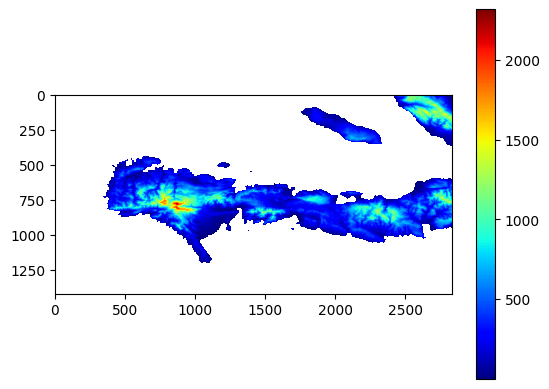

In [283]:
plt.imshow(DEM, cmap='jet')
plt.colorbar()
plt.show()

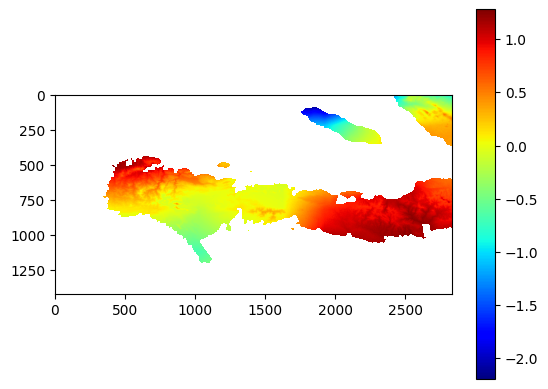

In [284]:
plt.imshow((TD - TD[750, 1500])*100, cmap='jet')
plt.colorbar()
plt.show()

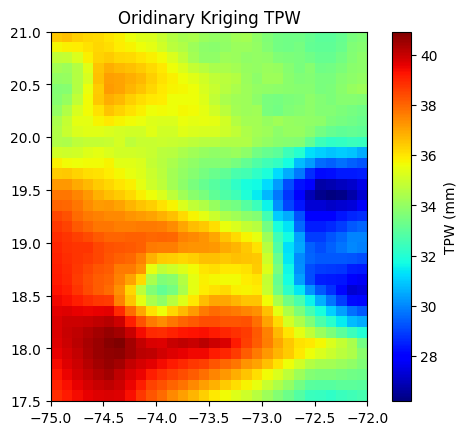

In [22]:
plt.imshow(estimate, cmap='jet', origin='lower', extent=[-75, -72, 17.5, 21])
plt.colorbar(label='TPW (mm)')
plt.title('Oridinary Kriging TPW')
plt.show()

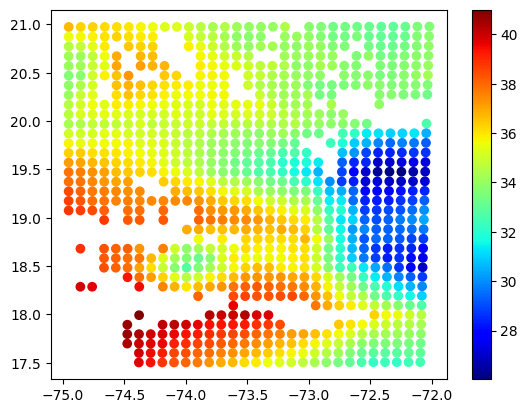

In [23]:
plt.scatter(ds.longitude.values, ds.latitude.values, c=tpw, cmap='jet')
plt.colorbar()
plt.show()

In [9]:
lats[np.isnan(ds.TPW)] = np.nan
lons[np.isnan(ds.TPW)] = np.nan

In [10]:
np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)

(-128.03696711125426, -54.08585090438682, 14.60949705527045, 54.00112763855694)

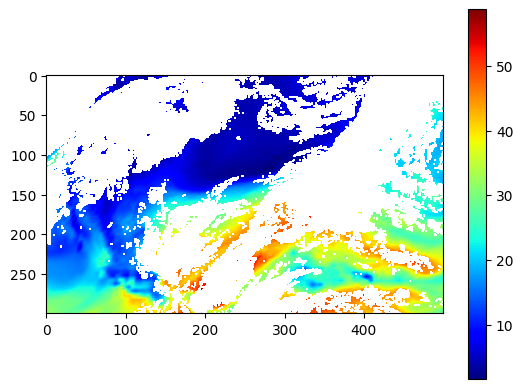

In [54]:
plt.imshow((ds1.TPW).values, cmap='jet')
plt.colorbar()
plt.show()

## Plotting different date of Ifg, WM_Raider, TPW_ZWD

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/066/10/OR_ABI-L2-TPWC-M6_G16_s20220661046170_e20220661048543_c20220661050590.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)
/tmp/ipykernel_33048/1524655536.py:70: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/078/10/OR_ABI-L2-TPWC-M6_G16_s20220781046168_e20220781048541_c20220781051021.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

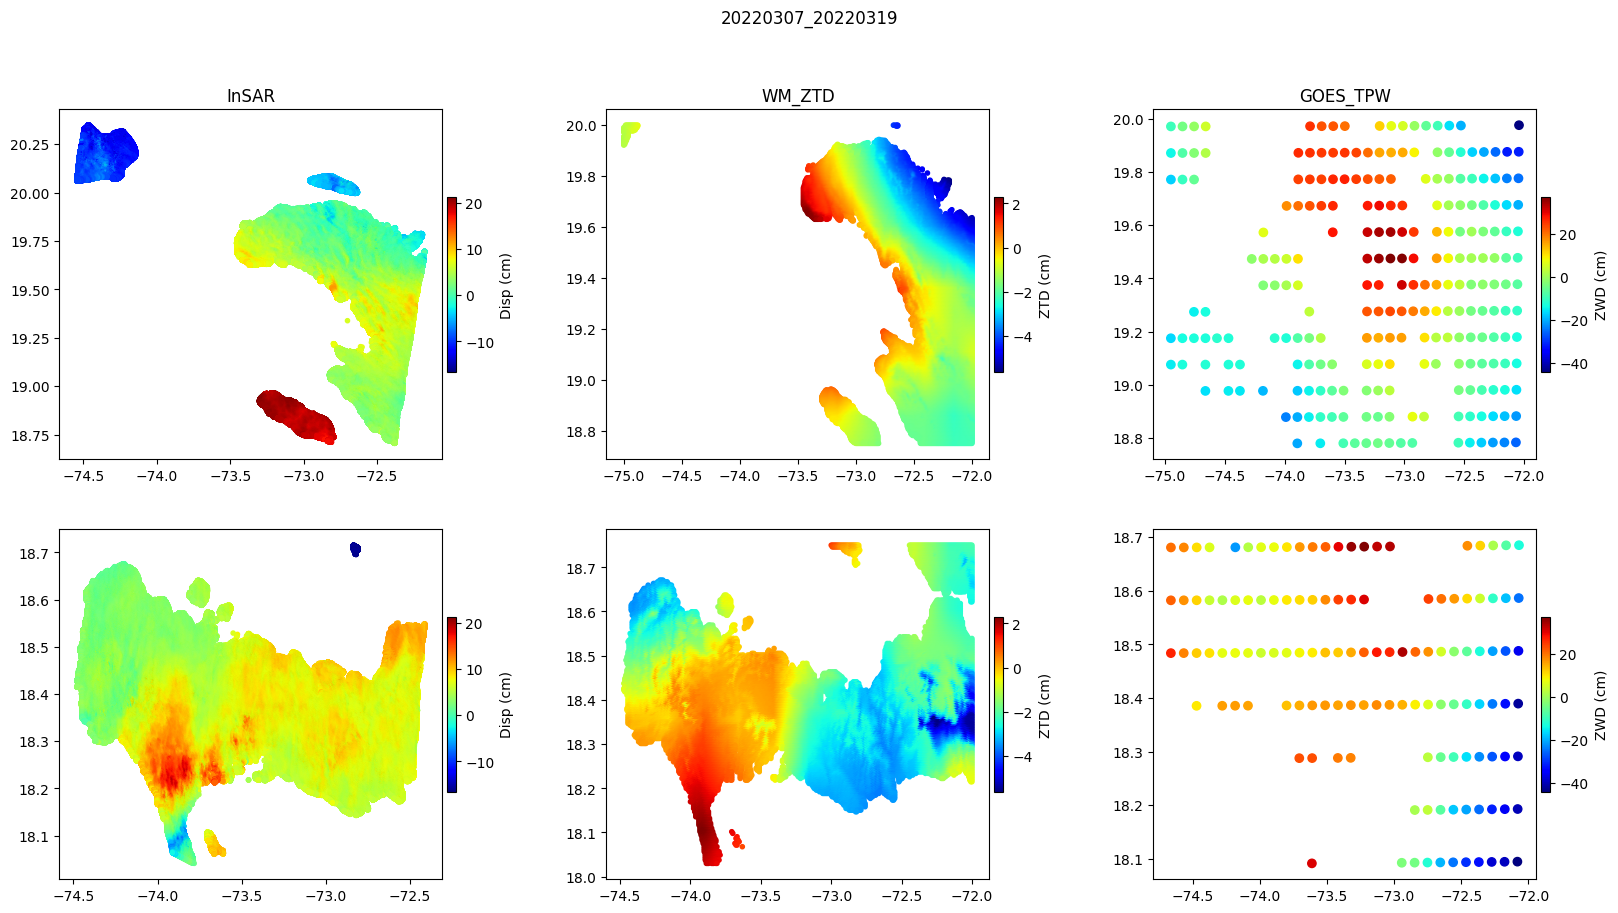

In [11]:
# Load Ifg
dataset = rasterio.open('TPW_InSAR/Haiti/20220307_20220319/filt_fine.unw')
ifg = dataset.read(2)
ifg[ifg==0] = np.nan
ifg[~mask] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)
N_ifg = ifg[1000:5000]
N_ifg = N_ifg - N_ifg[1500, 2000]
S_ifg = ifg[5000:7200]
S_ifg = S_ifg - S_ifg[1000, 4000]
N_LON = LON[1000:5000]
S_LON = LON[5000:7200]
N_LAT = LAT[1000:5000]
S_LAT = LAT[5000:7200]

# Load GOES TPW 
ds1 = goes_nearesttime('2022-03-07 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2022-03-19 10:47', product='ABI-L2-TPW', domain='C')
lons, lats = convert_rad_degree(ds1)

TPW_dat = pd.DataFrame(np.hstack((lons.ravel().reshape(-1,1), lats.ravel().reshape(-1,1), (ds2.TPW - ds1.TPW).values.ravel().reshape(-1,1))))

# Load weather model
wm1 = xr.load_dataset('weather_files/ERA-5_2022_03_07_T11_00_00_17N_22N_76W_70W.nc')
wm2 = xr.load_dataset('weather_files/ERA-5_2022_03_19_T11_00_00_17N_22N_76W_70W.nc')
hydro_interp1 = make_interpretor(wm1, 'hydro_total')
wet_interp1 = make_interpretor(wm1, 'wet_total')
hydro_interp2 = make_interpretor(wm2, 'hydro_total')
wet_interp2 = make_interpretor(wm2, 'wet_total')

# Load DEM
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM, _ = focus_bound(dem, -76, 17, -70, 21)
DEM[DEM<0.0]=np.nan

# Create grid for WM
X_lon = np.linspace(-75, -72, 400)
N_Y_lat = np.linspace(20, 18.75, 400)
S_Y_lat = np.linspace(18.75, 18, 200)
N_lon, N_lat = np.meshgrid(X_lon, N_Y_lat)
S_lon, S_lat = np.meshgrid(X_lon, S_Y_lat)
n_row, n_col = get_rowcol(dem, -76, 17, -70, 21, N_lon.ravel(), N_lat.ravel())
s_row, s_col = get_rowcol(dem, -76, 17, -70, 21, S_lon.ravel(), S_lat.ravel())
n_loc = np.hstack((N_lon.ravel().reshape(-1,1), N_lat.ravel().reshape(-1,1), DEM[n_row, n_col].ravel().reshape(-1,1)))
s_loc = np.hstack((S_lon.ravel().reshape(-1,1), S_lat.ravel().reshape(-1,1), DEM[s_row, s_col].ravel().reshape(-1,1)))
n_ZTD1 = hydro_interp1(n_loc) + wet_interp1(n_loc)
n_ZTD2 = hydro_interp2(n_loc) + wet_interp2(n_loc)
n_ZTD = n_ZTD2 - n_ZTD1
s_ZTD1 = hydro_interp1(s_loc) + wet_interp1(s_loc)
s_ZTD2 = hydro_interp2(s_loc) + wet_interp2(s_loc)
s_ZTD = s_ZTD2 - s_ZTD1
# n_ZTD_reshape = n_ZTD.reshape((400,300))
# s_ZTD_reshape = s_ZTD.reshape((400,300))

tpw_n = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <=20) & (TPW_dat[1] >= 18.75)]
tpw_s = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <18.75) & (TPW_dat[1] >= 18)]

# Plot
# int_TPW = (ds2.TPW.values[230:270,360:400] - ds.TPW.values[230:270,360:400])/10
fig, ax = plt.subplots(2,3, figsize=(20, 10))
im1 = ax[0, 0].scatter(N_LON.ravel(), N_LAT.ravel(), c =N_ifg.ravel(), marker='.', cmap='jet')
im2 = ax[0, 1].scatter(n_loc[:,0], n_loc[:,1], c = n_ZTD*100, marker='.', cmap='jet')
im3 = ax[0, 2].scatter(tpw_n[0], tpw_n[1], c = tpw_n[2]*6.2, cmap='jet')
im4 = ax[1, 0].scatter(S_LON.ravel(), S_LAT.ravel(), c =S_ifg.ravel(), marker='.', cmap='jet')
im5 = ax[1, 1].scatter(s_loc[:,0], s_loc[:,1], c = s_ZTD*100, marker='.', cmap='jet')
im6 = ax[1, 2].scatter(tpw_s[0], tpw_s[1], c = tpw_s[2]*6.2, cmap='jet')
ax[0, 0].set_title('InSAR')
ax[0, 1].set_title('WM_ZTD')
ax[0, 2].set_title('GOES_TPW')
plt.colorbar(im1, ax=ax[0,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[0,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[0,2], shrink=0.5, pad=.01, label='ZWD (cm)')
plt.colorbar(im1, ax=ax[1,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[1,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[1,2], shrink=0.5, pad=.01, label='ZWD (cm)')
fig.suptitle('20220307_20220319')
plt.show()

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/066/10/OR_ABI-L2-TPWC-M6_G16_s20220661046170_e20220661048543_c20220661050590.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/078/10/OR_ABI-L2-TPWC-M6_G16_s20220781046168_e20220781048541_c20220781051021.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/tmp/ipykernel_16787/1766674683.py:70: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


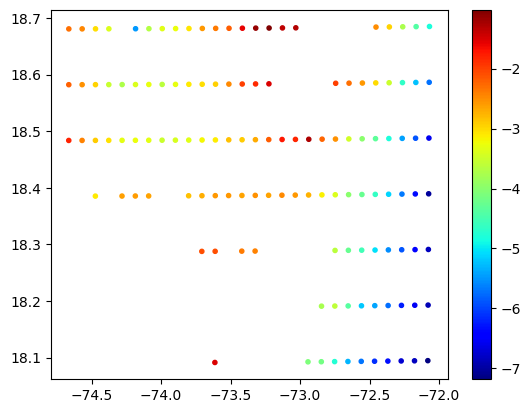

In [99]:
wm1 = xr.load_dataset('weather_files/ERA-5_2022_03_07_T11_00_00_17N_22N_76W_70W.nc')
wm2 = xr.load_dataset('weather_files/ERA-5_2022_03_19_T11_00_00_17N_22N_76W_70W.nc')
# Load GOES TPW 
# Load GOES TPW 
ds1 = goes_nearesttime('2022-03-07 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2022-03-19 10:47', product='ABI-L2-TPW', domain='C')
lons, lats = radian2degree(ds1)
lats[np.isinf(lats)] = np.nan
lons[np.isinf(lons)] = np.nan

TPW_dat = pd.DataFrame(np.hstack((lons.ravel().reshape(-1,1), lats.ravel().reshape(-1,1), (ds2.TPW - ds1.TPW).values.ravel().reshape(-1,1))))
tpw_n = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <=20) & (TPW_dat[1] >= 18.75)]
tpw_s = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <18.75) & (TPW_dat[1] >= 18)]
plt.scatter(tpw_s[0], tpw_s[1], c = tpw_s[2], cmap='jet', marker='.')
plt.colorbar()
plt.show()

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/030/10/OR_ABI-L2-TPWC-M6_G16_s20220301046173_e20220301048546_c20220301051012.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2022/042/10/OR_ABI-L2-TPWC-M6_G16_s20220421046172_e20220421048545_c20220421050486.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/tmp/ipykernel_16787/1600275798.py:70: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


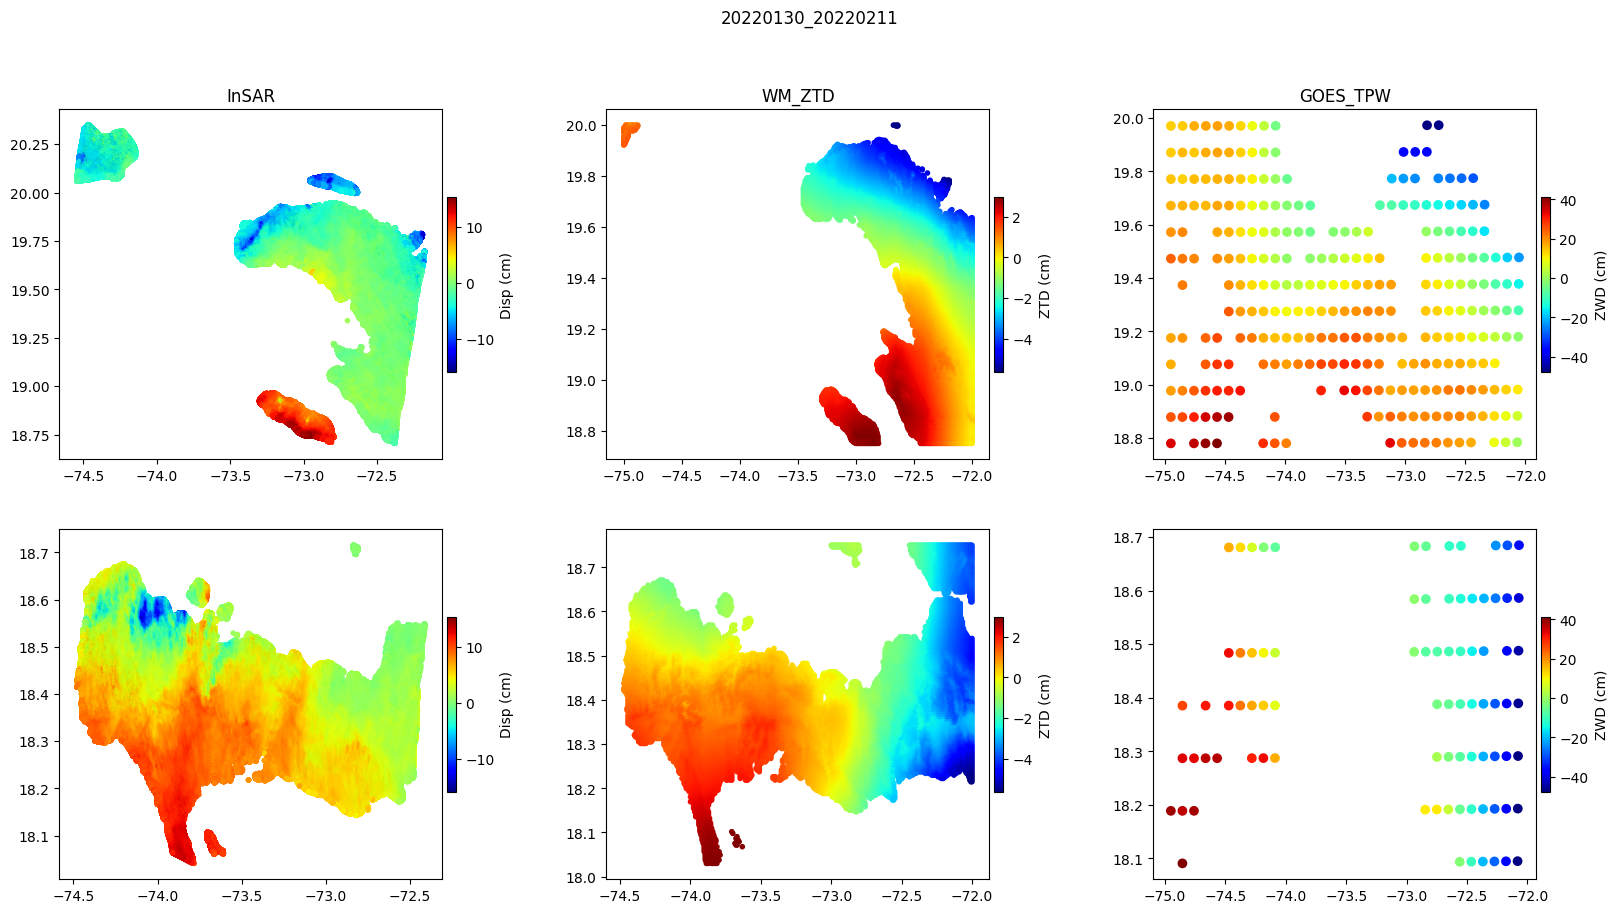

In [145]:
# Load Ifg
dataset = rasterio.open('TPW_InSAR/Haiti/20220130_20220211/filt_fine.unw')
ifg = dataset.read(2)
ifg[ifg==0] = np.nan
ifg[~mask] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)
N_ifg = ifg[1000:5000]
N_ifg = N_ifg - N_ifg[1500, 2000]
S_ifg = ifg[5000:7200]
S_ifg = S_ifg - S_ifg[1000, 4000]
N_LON = LON[1000:5000]
S_LON = LON[5000:7200]
N_LAT = LAT[1000:5000]
S_LAT = LAT[5000:7200]

# Load GOES TPW 
ds1 = goes_nearesttime('2022-01-30 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2022-02-11 10:47', product='ABI-L2-TPW', domain='C')
lons, lats = convert_rad_degree(ds1)

TPW_dat = pd.DataFrame(np.hstack((lons.ravel().reshape(-1,1), lats.ravel().reshape(-1,1), (ds2.TPW - ds1.TPW).values.ravel().reshape(-1,1))))

# Load weather model
wm1 = xr.load_dataset('weather_files/ERA-5_2022_01_30_T11_00_00_17N_22N_76W_70W.nc')
wm2 = xr.load_dataset('weather_files/ERA-5_2022_02_11_T11_00_00_17N_22N_76W_70W.nc')
hydro_interp1 = make_interpretor(wm1, 'hydro_total')
wet_interp1 = make_interpretor(wm1, 'wet_total')
hydro_interp2 = make_interpretor(wm2, 'hydro_total')
wet_interp2 = make_interpretor(wm2, 'wet_total')

# Load DEM
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM, _ = focus_bound(dem, -76, 17, -70, 21)
DEM[DEM<0.0]=np.nan

# Create grid for WM
X_lon = np.linspace(-75, -72, 400)
N_Y_lat = np.linspace(20, 18.75, 400)
S_Y_lat = np.linspace(18.75, 18, 200)
N_lon, N_lat = np.meshgrid(X_lon, N_Y_lat)
S_lon, S_lat = np.meshgrid(X_lon, S_Y_lat)
n_row, n_col = get_rowcol(dem, -76, 17, -70, 21, N_lon.ravel(), N_lat.ravel())
s_row, s_col = get_rowcol(dem, -76, 17, -70, 21, S_lon.ravel(), S_lat.ravel())
n_loc = np.hstack((N_lon.ravel().reshape(-1,1), N_lat.ravel().reshape(-1,1), DEM[n_row, n_col].ravel().reshape(-1,1)))
s_loc = np.hstack((S_lon.ravel().reshape(-1,1), S_lat.ravel().reshape(-1,1), DEM[s_row, s_col].ravel().reshape(-1,1)))
n_ZTD1 = hydro_interp1(n_loc) + wet_interp1(n_loc)
n_ZTD2 = hydro_interp2(n_loc) + wet_interp2(n_loc)
n_ZTD = n_ZTD2 - n_ZTD1
s_ZTD1 = hydro_interp1(s_loc) + wet_interp1(s_loc)
s_ZTD2 = hydro_interp2(s_loc) + wet_interp2(s_loc)
s_ZTD = s_ZTD2 - s_ZTD1
# n_ZTD_reshape = n_ZTD.reshape((400,300))
# s_ZTD_reshape = s_ZTD.reshape((400,300))

tpw_n = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <=20) & (TPW_dat[1] >= 18.75)]
tpw_s = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <18.75) & (TPW_dat[1] >= 18)]

# Plot
# int_TPW = (ds2.TPW.values[230:270,360:400] - ds.TPW.values[230:270,360:400])/10
fig, ax = plt.subplots(2,3, figsize=(20, 10))
im1 = ax[0, 0].scatter(N_LON.ravel(), N_LAT.ravel(), c =N_ifg.ravel(), marker='.', cmap='jet')
im2 = ax[0, 1].scatter(n_loc[:,0], n_loc[:,1], c = n_ZTD*100, marker='.', cmap='jet')
im3 = ax[0, 2].scatter(tpw_n[0], tpw_n[1], c = tpw_n[2]*6.2, cmap='jet')
im4 = ax[1, 0].scatter(S_LON.ravel(), S_LAT.ravel(), c =S_ifg.ravel(), marker='.', cmap='jet')
im5 = ax[1, 1].scatter(s_loc[:,0], s_loc[:,1], c = s_ZTD*100, marker='.', cmap='jet')
im6 = ax[1, 2].scatter(tpw_s[0], tpw_s[1], c = tpw_s[2]*6.2, cmap='jet')
ax[0, 0].set_title('InSAR')
ax[0, 1].set_title('WM_ZTD')
ax[0, 2].set_title('GOES_TPW')
plt.colorbar(im1, ax=ax[0,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[0,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[0,2], shrink=0.5, pad=.01, label='ZWD (cm)')
plt.colorbar(im1, ax=ax[1,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[1,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[1,2], shrink=0.5, pad=.01, label='ZWD (cm)')
fig.suptitle('20220130_20220211')
plt.show()

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/299/10/OR_ABI-L2-TPWC-M6_G16_s20212991046174_e20212991048547_c20212991050291.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/305/10/OR_ABI-L2-TPWC-M6_G16_s20213051046170_e20213051048543_c20213051050244.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/tmp/ipykernel_16787/1600275798.py:70: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


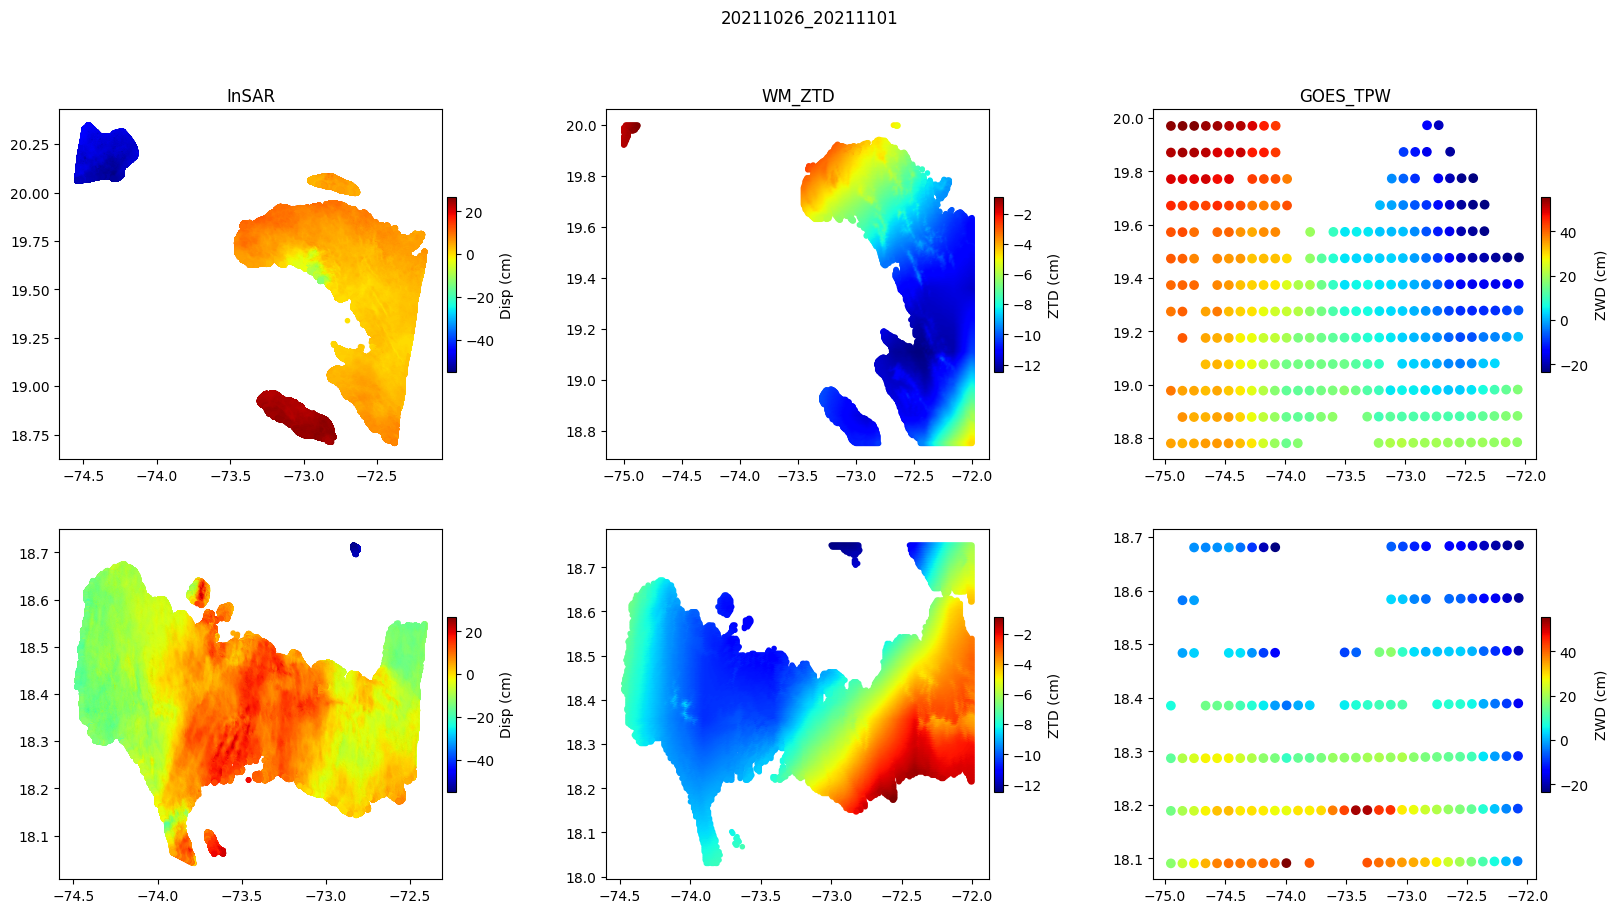

In [146]:
# Load ifg
dataset = rasterio.open('TPW_InSAR/Haiti/20211026_20211101/filt_fine.unw')

# Load GOES TPW 
ds = goes_nearesttime('2021-10-26 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2021-11-01 10:47', product='ABI-L2-TPW', domain='C')

# Load weather model
wm1 = xr.load_dataset('weather_files/ERA-5_2021_10_26_T11_00_00_17N_22N_76W_70W.nc')
wm2 = xr.load_dataset('weather_files/ERA-5_2021_11_01_T11_00_00_17N_22N_76W_70W.nc')

ifg = dataset.read(2)
ifg[ifg==0] = np.nan
ifg[~mask] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)
N_ifg = ifg[1000:5000]
N_ifg = N_ifg - N_ifg[1500, 2000]
S_ifg = ifg[5000:7200]
S_ifg = S_ifg - S_ifg[1000, 4000]
N_LON = LON[1000:5000]
S_LON = LON[5000:7200]
N_LAT = LAT[1000:5000]
S_LAT = LAT[5000:7200]

# Load GOES TPW 
lons, lats = convert_rad_degree(ds1)

TPW_dat = pd.DataFrame(np.hstack((lons.ravel().reshape(-1,1), lats.ravel().reshape(-1,1), (ds2.TPW - ds1.TPW).values.ravel().reshape(-1,1))))

hydro_interp1 = make_interpretor(wm1, 'hydro_total')
wet_interp1 = make_interpretor(wm1, 'wet_total')
hydro_interp2 = make_interpretor(wm2, 'hydro_total')
wet_interp2 = make_interpretor(wm2, 'wet_total')

# Load DEM
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM, _ = focus_bound(dem, -76, 17, -70, 21)
DEM[DEM<0.0]=np.nan

# Create grid for WM
X_lon = np.linspace(-75, -72, 400)
N_Y_lat = np.linspace(20, 18.75, 400)
S_Y_lat = np.linspace(18.75, 18, 200)
N_lon, N_lat = np.meshgrid(X_lon, N_Y_lat)
S_lon, S_lat = np.meshgrid(X_lon, S_Y_lat)
n_row, n_col = get_rowcol(dem, -76, 17, -70, 21, N_lon.ravel(), N_lat.ravel())
s_row, s_col = get_rowcol(dem, -76, 17, -70, 21, S_lon.ravel(), S_lat.ravel())
n_loc = np.hstack((N_lon.ravel().reshape(-1,1), N_lat.ravel().reshape(-1,1), DEM[n_row, n_col].ravel().reshape(-1,1)))
s_loc = np.hstack((S_lon.ravel().reshape(-1,1), S_lat.ravel().reshape(-1,1), DEM[s_row, s_col].ravel().reshape(-1,1)))
n_ZTD1 = hydro_interp1(n_loc) + wet_interp1(n_loc)
n_ZTD2 = hydro_interp2(n_loc) + wet_interp2(n_loc)
n_ZTD = n_ZTD2 - n_ZTD1
s_ZTD1 = hydro_interp1(s_loc) + wet_interp1(s_loc)
s_ZTD2 = hydro_interp2(s_loc) + wet_interp2(s_loc)
s_ZTD = s_ZTD2 - s_ZTD1
# n_ZTD_reshape = n_ZTD.reshape((400,300))
# s_ZTD_reshape = s_ZTD.reshape((400,300))

tpw_n = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <=20) & (TPW_dat[1] >= 18.75)]
tpw_s = TPW_dat[(TPW_dat[0]<-72) & (TPW_dat[0]>-75) & (TPW_dat[1] <18.75) & (TPW_dat[1] >= 18)]

# Plot
# int_TPW = (ds2.TPW.values[230:270,360:400] - ds.TPW.values[230:270,360:400])/10
fig, ax = plt.subplots(2,3, figsize=(20, 10))
im1 = ax[0, 0].scatter(N_LON.ravel(), N_LAT.ravel(), c =N_ifg.ravel(), marker='.', cmap='jet')
im2 = ax[0, 1].scatter(n_loc[:,0], n_loc[:,1], c = n_ZTD*100, marker='.', cmap='jet')
im3 = ax[0, 2].scatter(tpw_n[0], tpw_n[1], c = tpw_n[2]*6.2, cmap='jet')
im4 = ax[1, 0].scatter(S_LON.ravel(), S_LAT.ravel(), c =S_ifg.ravel(), marker='.', cmap='jet')
im5 = ax[1, 1].scatter(s_loc[:,0], s_loc[:,1], c = s_ZTD*100, marker='.', cmap='jet')
im6 = ax[1, 2].scatter(tpw_s[0], tpw_s[1], c = tpw_s[2]*6.2, cmap='jet')
ax[0, 0].set_title('InSAR')
ax[0, 1].set_title('WM_ZTD')
ax[0, 2].set_title('GOES_TPW')
plt.colorbar(im1, ax=ax[0,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[0,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[0,2], shrink=0.5, pad=.01, label='ZWD (cm)')
plt.colorbar(im1, ax=ax[1,0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[1,1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[1,2], shrink=0.5, pad=.01, label='ZWD (cm)')
fig.suptitle('20211026_20211101')
plt.show()

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/323/10/OR_ABI-L2-TPWC-M6_G16_s20213231046172_e20213231048545_c20213231050367.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/329/10/OR_ABI-L2-TPWC-M6_G16_s20213291046175_e20213291048548_c20213291050195.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

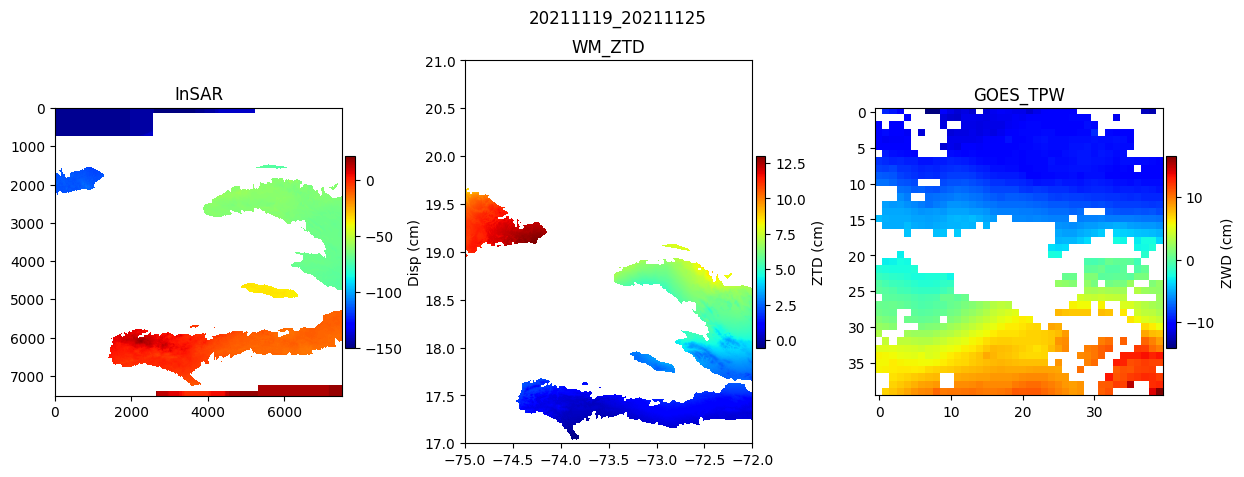

In [52]:
# Load ifg
dataset = rasterio.open('TPW_InSAR/Haiti/20211119_20211125/filt_fine.unw')
ifg = dataset.read(2)
ifg[ifg==0] = np.nan
ifg[~mask] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)

# Load GOES TPW 
ds = goes_nearesttime('2021-11-19 10:47', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2021-11-25 10:47', product='ABI-L2-TPW', domain='C')

# Load weather model
wm1 = xr.load_dataset('weather_files/ERA-5_2021_11_19_T11_00_00_17N_22N_76W_70W.nc')
wm2 = xr.load_dataset('weather_files/ERA-5_2021_11_25_T11_00_00_17N_22N_76W_70W.nc')
hydro_interp1 = make_interpretor(wm1, 'hydro_total')
wet_interp1 = make_interpretor(wm1, 'wet_total')
hydro_interp2 = make_interpretor(wm2, 'hydro_total')
wet_interp2 = make_interpretor(wm2, 'wet_total')
dem = 'DEM/Haiti/glo_90_ellipsoidal_Point.tif'
DEM = rasterio.open(dem).read(1)
DEM[DEM<0.0]=np.nan
X_lon = np.linspace(-75, -72, 300)
Y_lat = np.linspace(21, 17, 400)
X_lon, Y_lat = np.meshgrid(X_lon, Y_lat)
row, col = get_rowcol(dem, -76, 17, -70, 21, X_lon.ravel(), Y_lat.ravel())
loc = np.hstack((X_lon.ravel().reshape(-1,1), Y_lat.ravel().reshape(-1,1), DEM[row, col].ravel().reshape(-1,1)))
ZTD1 = hydro_interp1(loc) + wet_interp1(loc)
ZTD2 = hydro_interp2(loc) + wet_interp2(loc)
ZTD = ZTD2 - ZTD1
ZTD_reshape = ZTD.reshape((400,300))

# Plot
int_TPW = (ds2.TPW.values[210:250,345:385] - ds.TPW.values[210:250,345:385])/10
fig, ax = plt.subplots(1,3, figsize=(15, 5))
im1 = ax[0].imshow(np.fliplr(ifg-ifg[6000, 4000]), cmap='jet')
im2 = ax[1].imshow((ZTD_reshape)*100, cmap='jet', extent=[ -75, -72, 17, 21 ])
im3 = ax[2].imshow(int_TPW*6.2, cmap='jet')
ax[0].set_title('InSAR')
ax[1].set_title('WM_ZTD')
ax[2].set_title('GOES_TPW')
plt.colorbar(im1, ax=ax[0], shrink=0.5, pad=.01, label='Disp (cm)')
plt.colorbar(im2, ax=ax[1], shrink=0.5, pad=.01, label='ZTD (cm)')
plt.colorbar(im3, ax=ax[2], shrink=0.5, pad=.01, label='ZWD (cm)')
fig.suptitle('20211119_20211125')
plt.show()

In [453]:
# Maybe create a regular grid interpretor to fill out the empty area/
# As of right now, it does not quite work because the data is not regular grid. We somehow need to reproject it to the EQC.
# Kriging should work though
lat, lon = convert_rad_degree(ds)
data = pd.DataFrame(np.hstack((lon.ravel().reshape(-1,1), lat.ravel().reshape(-1,1), ds.TPW.values.ravel().reshape(-1,1))))
Data_ = pd.DataFrame(data)
Data_ = Data_[(Data_[0] < -72) & (Data_[0] > -75) & (Data_[1] < 21) & (Data_[1] > 17.5)]
Data_[0] = Data_[0].round(1)
Data_[1] = Data_[1].round(1)
x = list(set(Data_[0]))
y = list(set(Data_[1]))
x.sort()
y.sort(reverse=True)
interpolator = rgi(points=(y, x), values=Data_[2].values.reshape((len(y), len(x))), method='linear', bounds_error=False)

/tmp/ipykernel_44023/305971195.py:56: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Plotting TPW on a map

In [140]:
crs, x, y = abi_crs(ds, 'TPW')

Text(0.5, 1.0, '10:47 UTC 07 Mar 2022')

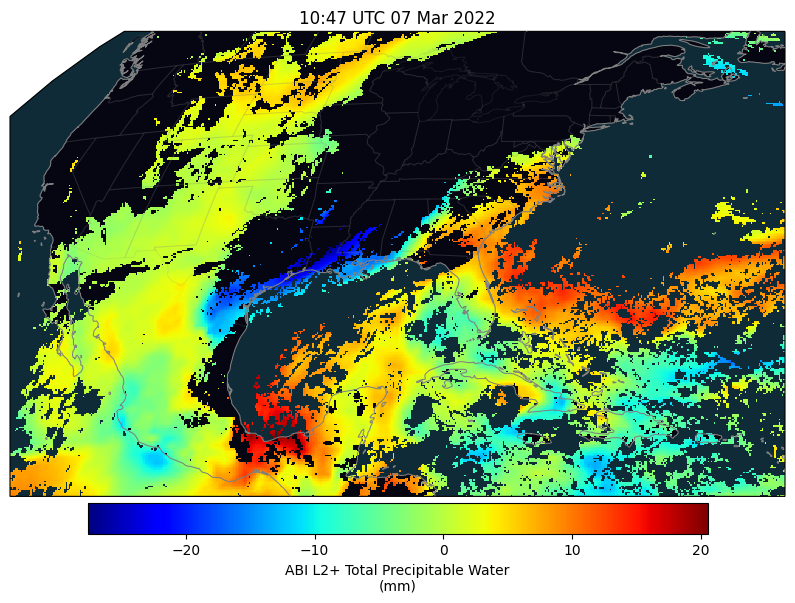

In [303]:
ax = common_features('50m', crs=ds.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds2.TPW- ds.TPW, transform=ds.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds.TPW.long_name}\n({ds.TPW.units})")
ax.set_title(f"{ds.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

Text(0.5, 1.0, '10:47 UTC 19 Mar 2022')

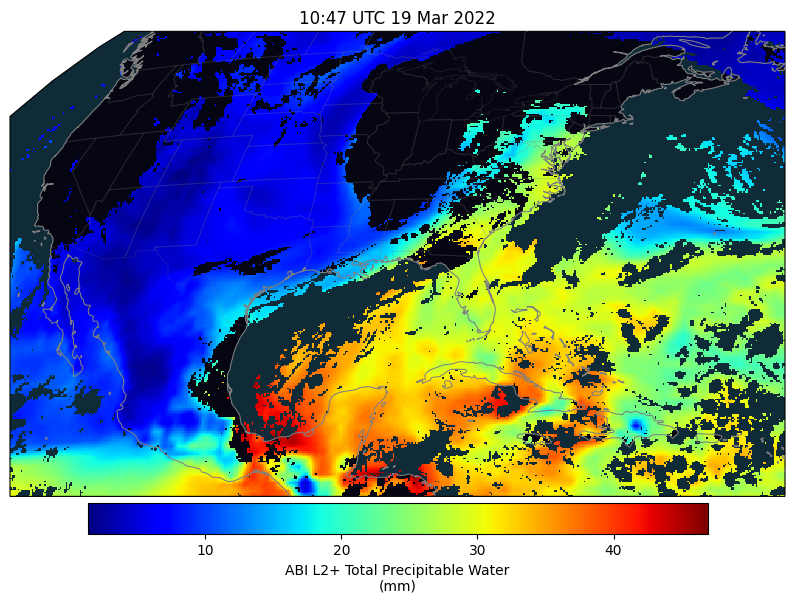

In [279]:
ax = common_features('50m', crs=ds2.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds2.TPW, transform=ds2.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds2.TPW.long_name}\n({ds2.TPW.units})")
ax.set_title(f"{ds2.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

# Process lat lon of GOES data

In [45]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [46]:
lat, lon = convert_rad_degree(ds)

/tmp/ipykernel_35904/3369206428.py:40: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


In [ ]:
np.nanmin(lat), np.nanmax(lat), np.nanmin(lon), np.nanmax(lon)

(14.609497055751815, 56.46728120956484, -151.40819141226552, -53.0607252997885)

Haiti focus area approximate -74.5,-71, 17.5, 21

In [157]:
data = pd.DataFrame(np.hstack((lon.ravel().reshape(-1,1), lat.ravel().reshape(-1,1), ds.TPW.values.ravel().reshape(-1,1))))
data2 = pd.DataFrame(np.hstack((lon.ravel().reshape(-1,1), lat.ravel().reshape(-1,1), ds2.TPW.values.ravel().reshape(-1,1))))

In [158]:
Data_ = pd.DataFrame(data)
Data_2 = pd.DataFrame(data2)
Data_ = Data_[(Data_[0] < -71.5) & (Data_[0] > -75) & (Data_[1] < 21) & (Data_[1] > 17.5)]
Data_2 = Data_2[(Data_2[0] < -71.5) & (Data_2[0] > -75) & (Data_2[1] < 21) & (Data_2[1] > 17.5)]

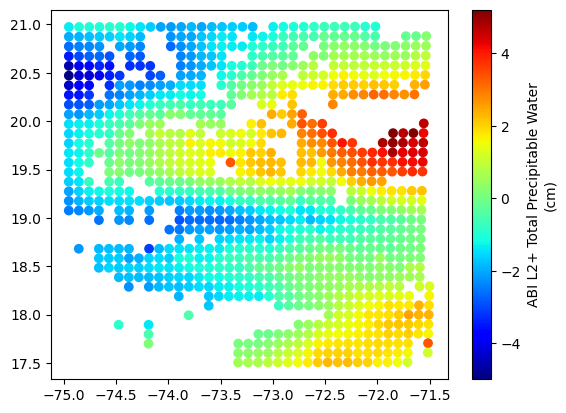

In [163]:
plt.scatter(Data_[0], Data_[1], c=((Data_2[2]-Data_[2])/1.5) - np.nanmean((Data_2[2]-Data_[2])/1.5), cmap='jet')
plt.colorbar(label=f"{ds.TPW.long_name}\n(cm)")
plt.show()

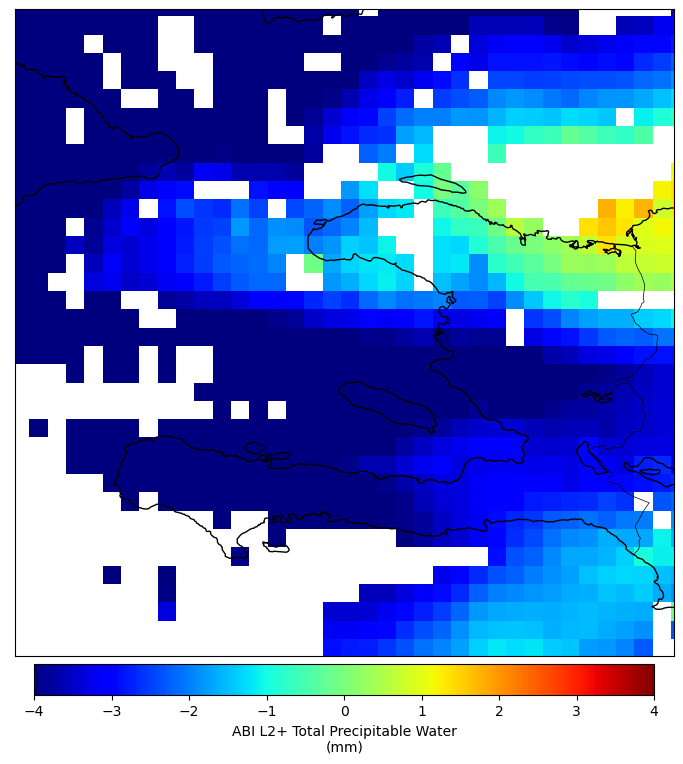

In [174]:
mM1 = Basemap(projection='geos',
            rsphere=(6378137.00,6356752.3142),
            resolution='h',
            lon_0=-75,
            satellite_height=35785831,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

plt.figure(figsize=[10, 10])
a = mM1.imshow((np.flipud(ds2.TPW - ds.TPW))/1.5, cmap='jet', vmin=-4, vmax=4) # Remember, "images" are upside down, so flip up/down
mM1.drawcoastlines()
mM1.drawcountries()
mM1.drawstates()
plt.colorbar(a, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds.TPW.long_name}\n({ds.TPW.units})")
ax = plt.gca()
xmin, ymin = mM1(-75, 17.5)
xmax, ymax = mM1(-71.5, 21)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

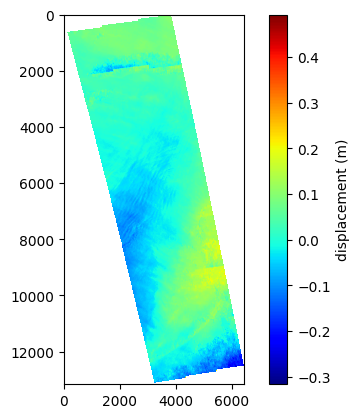

In [30]:
sar_path = 'InSAR/Large_scale/East/Extracted/unwrappedPhase/20211028_20211016'
pen_dataset = rasterio.open(sar_path)
SAR = pen_dataset.read(1)
SAR[SAR==0] = np.nan
SAR = convert_rad(SAR, 0.056)
plt.imshow(SAR - SAR[6000, 4000], cmap='jet')
plt.colorbar(label='displacement (m)')
plt.show()

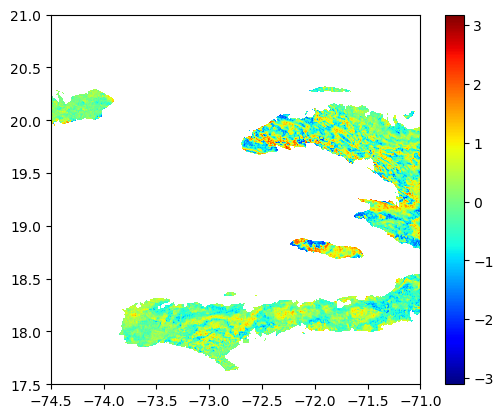

In [181]:
plt.imshow(np.flip(ifg - np.nanmean(ifg),1), cmap='jet', extent=[-74.5,-71, 17.5, 21])
plt.colorbar()
plt.show()

In [25]:
update_ds = calc_latlon(ds)

/tmp/ipykernel_62733/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


# Hawaii Test

In [42]:
lon_min, lat_min, lon_max, lat_max = -155.9, 18.9, -154.9, 19.9

In [111]:
ifg, grid = focus_bound('InSAR/Hawaii/products/Extracted/unwrappedPhase/20191123_20191117', lon_min, lat_min, lon_max, lat_max)

In [112]:
DEM, _ = Resamp_rasterio('/home/nyv62/Store1/Kenny/InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif',lon_min, lat_min, lon_max, lat_max, ifg)
DEM[DEM<=0.0] = np.nan
mask = DEM.copy()

In [122]:
ifg[np.isnan(mask)] = np.nan
ifg = convert_rad(ifg, 5.6)

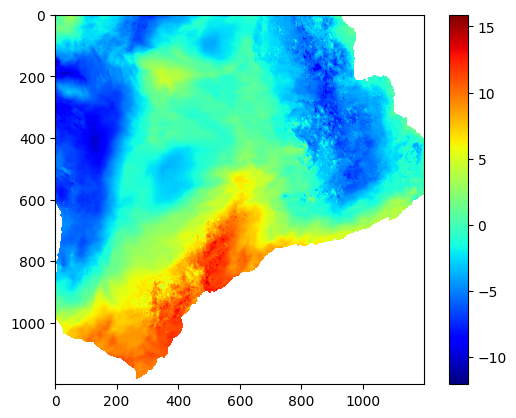

In [46]:
plt.imshow(ifg - ifg[500,500], cmap='jet')
# extent = [-155.9, -154.9, 18.9, 19.9])
plt.colorbar()
plt.show()

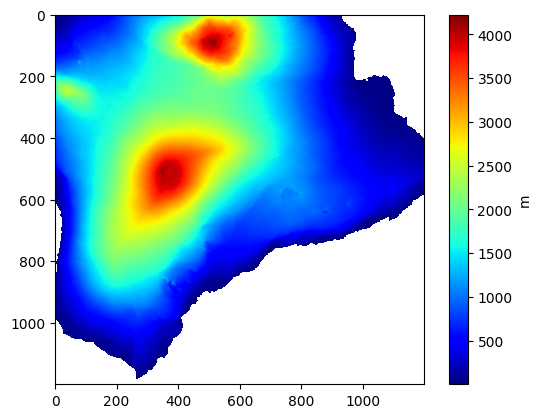

In [18]:
plt.imshow(DEM, cmap='jet')
plt.colorbar(label='m')
plt.show()

In [53]:
ds1 = xr.load_dataset('GOES_data/data/noaa-goes17/ABI-L2-TPWC/Hawaii/OR_ABI-L2-TPWC-M6_G17_s20193210431197_e20193210433570_c20193210435135.nc')
ds2 = xr.load_dataset('GOES_data/data/noaa-goes17/ABI-L2-TPWC/Hawaii/OR_ABI-L2-TPWC-M6_G17_s20193270426197_e20193270428570_c20193270430042.nc')

In [54]:
crs, x, y = abi_crs(ds1, 'TPW')

Text(0.5, 1.0, '04:32 UTC 17 Nov 2019')

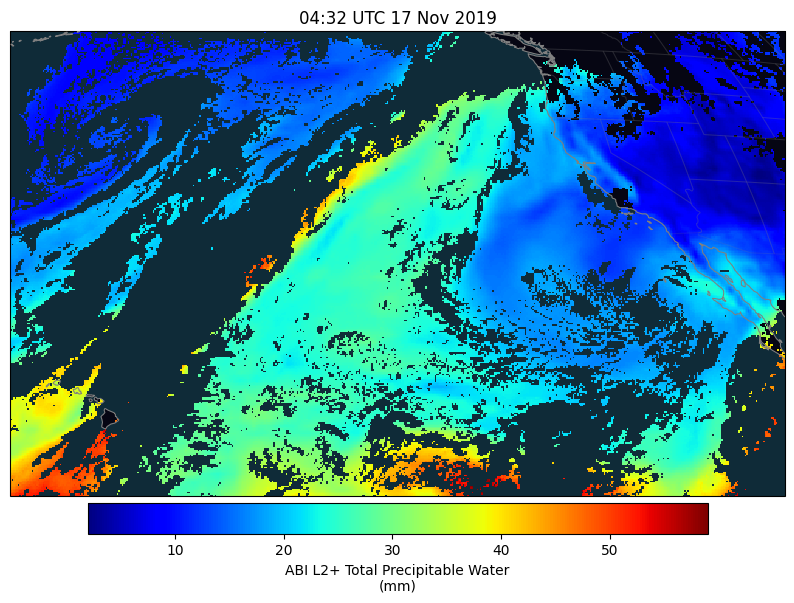

In [55]:
ax = common_features('50m', crs=ds1.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds1.TPW, transform=ds1.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds1.TPW.long_name}\n({ds1.TPW.units})")
ax.set_title(f"{ds1.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

Text(0.5, 1.0, '04:27 UTC 23 Nov 2019')

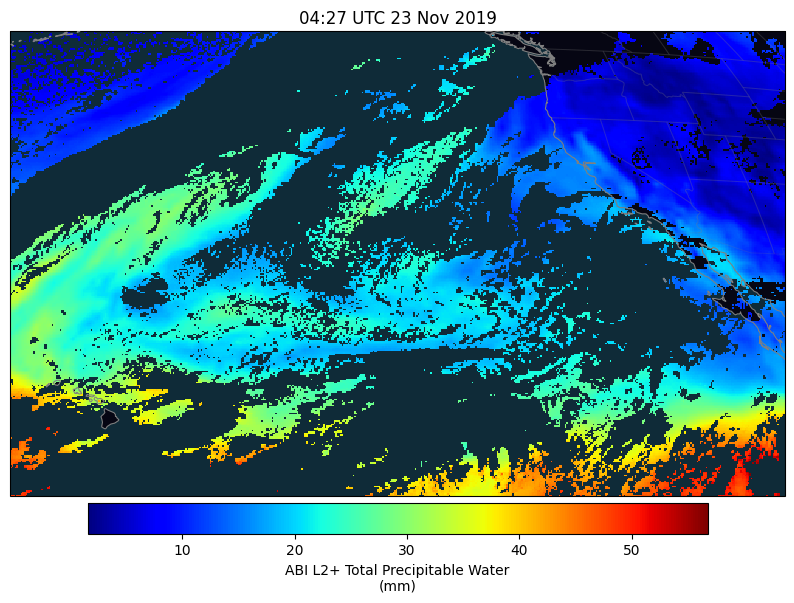

In [56]:
ax = common_features('50m', crs=ds2.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds2.TPW, transform=ds2.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds2.TPW.long_name}\n({ds2.TPW.units})")
ax.set_title(f"{ds2.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

## GOES TPW tropo delayy prediciton

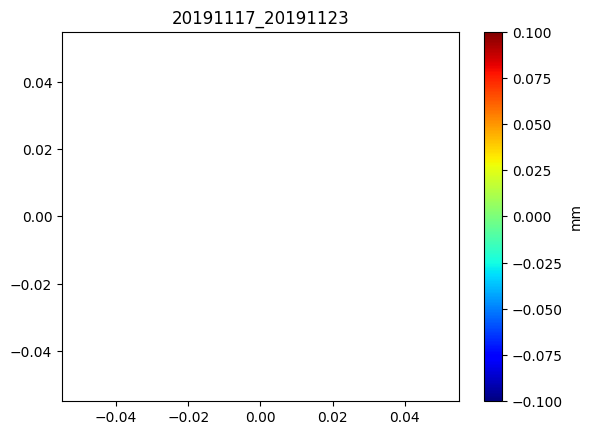

In [40]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < lon_max) & (DS1.lon > lon_min) & (DS1.lat > lat_min) & (DS1.lat < lat_max))
tpw2 = DS2.where((DS2.lon < lon_max) & (DS2.lon > lon_min) & (DS2.lat > lat_min) & (DS2.lat < lat_max))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values), cmap='jet')
plt.title('20191117_20191123')
plt.colorbar(label='mm')
plt.show()

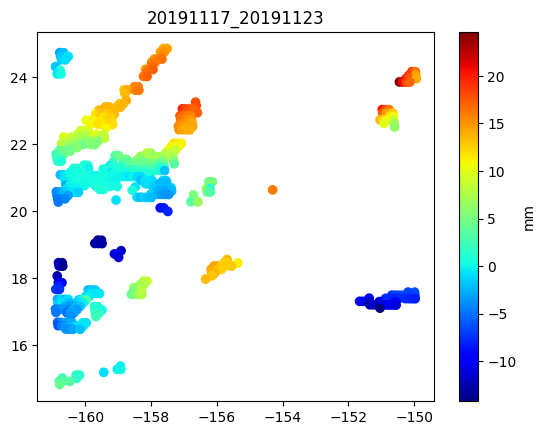

In [57]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < lon_max+5) & (DS1.lon > lon_min-5) & (DS1.lat > lat_min-5) & (DS1.lat < lat_max+5))
tpw2 = DS2.where((DS2.lon < lon_max+5) & (DS2.lon > lon_min-5) & (DS2.lat > lat_min-5) & (DS2.lat < lat_max+5))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values), cmap='jet')
plt.title('20191117_20191123')
plt.colorbar(label='mm')
plt.show()

In [58]:
# Import Library
from pykrige.ok import OrdinaryKriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 73.90090282509085
Full Sill: 73.90091579602505
Range: 7.466995167748749
Nugget: 1.2970934199259647e-05 



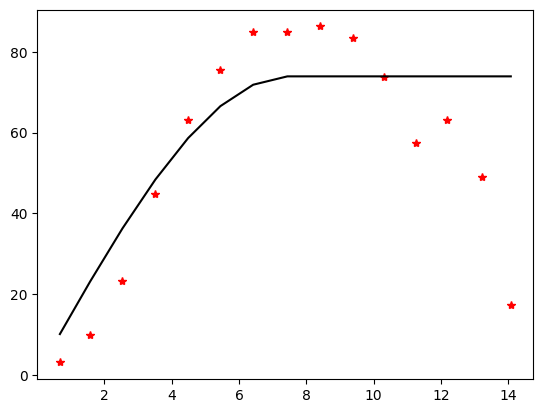

Calculating statistics on variogram model fit...


In [59]:
clean_tpw_1 = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw1.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw_1[0]
y = clean_tpw_1[1]
val = clean_tpw_1[2]
OK_1 = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True, nlags=15)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 114.03287369938924
Full Sill: 114.03287369939528
Range: 14.135216582284412
Nugget: 6.034760153795764e-12 



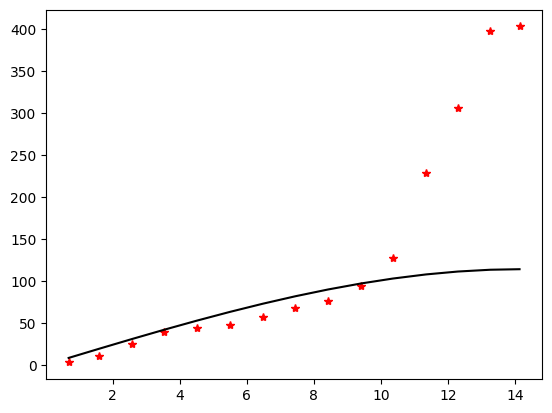

Calculating statistics on variogram model fit...


In [60]:
clean_tpw_2 = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw2.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw_2[0]
y = clean_tpw_2[1]
val = clean_tpw_2[2]
OK_2 = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True, nlags=15)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 73.90090282509085
Full Sill: 73.90091579602505
Range: 7.466995167748749
Nugget: 1.2970934199259647e-05 



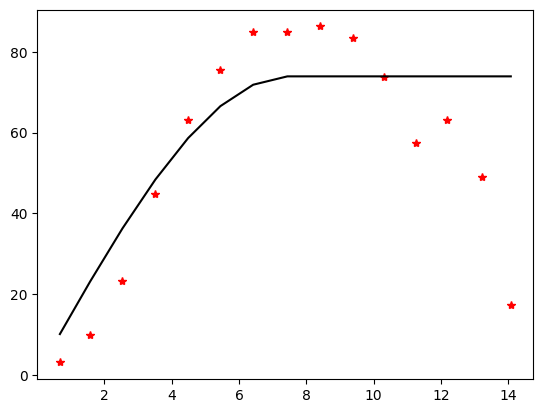

Calculating statistics on variogram model fit...


In [61]:
clean_tpw_1 = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw1.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw_1[0]
y = clean_tpw_1[1]
val = clean_tpw_1[2]
OK = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True, nlags=15)

In [62]:
gridx = np.linspace(lon_min, lon_max, 200)
gridy = np.linspace(lat_max, lat_min, 200)
estimate, ss = OK.execute('grid', gridx, gridy)
estimate_1, ss1 = OK_1.execute('grid', gridx, gridy)
estimate_2, ss2 = OK_2.execute('grid', gridx, gridy)

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [70]:
X = np.linspace(lon_min, lon_max, ifg.shape[0])
Y = np.linspace(lat_max, lat_min, ifg.shape[0])
X, Y = np.meshgrid(X, Y)
grid = np.stack([Y.ravel(), X.ravel()], axis=-1)

In [71]:
TPW_interp = rgi(points=(gridy, gridx), values=estimate.data, bounds_error=False)(grid)
TPW_interp = TPW_interp.reshape(ifg.shape)
TPW_1 = rgi(points=(gridy, gridx), values=estimate_1.data, bounds_error=False)(grid)
TPW_1 = TPW_1.reshape(ifg.shape)
TPW_2 = rgi(points=(gridy, gridx), values=estimate_2.data, bounds_error=False)(grid)
TPW_2 = TPW_2.reshape(ifg.shape)

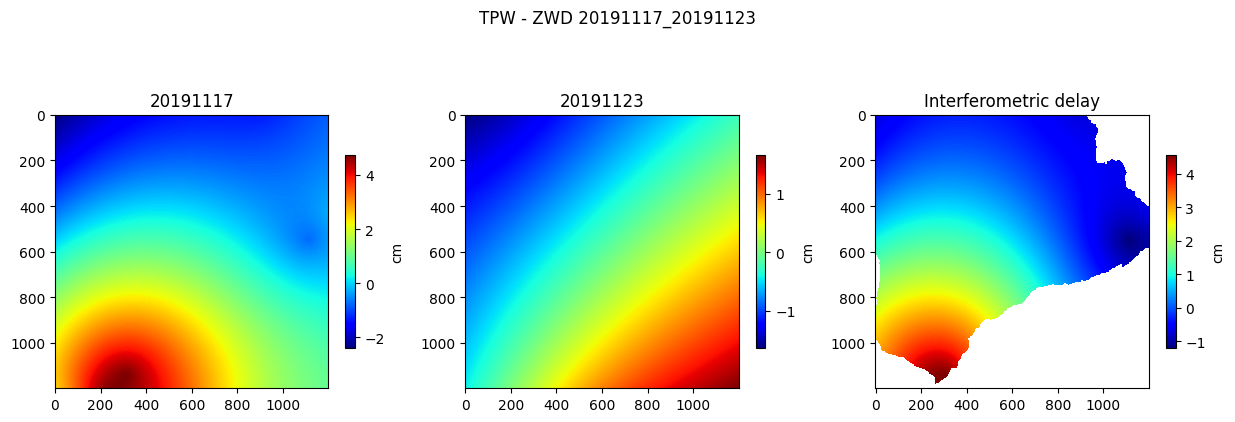

In [128]:
TPW_ = (TPW_1 - TPW_2)
TPW_[np.isnan(mask)] = np.nan
TPW_interp[np.isnan(mask)] = np.nan
fig, ax = plt.subplots(1,3, figsize=(15,5))
im1 = ax[0].imshow((TPW_1 - TPW_1[500,800])*0.62, cmap='jet')
im2 = ax[1].imshow((TPW_2 - TPW_2[500,800])*0.62, cmap='jet')
im3 = ax[2].imshow((TPW_ - TPW_[500,800])*0.62, cmap='jet')
ax[0].title.set_text('20191117')
ax[1].title.set_text('20191123')
ax[2].title.set_text('Interferometric delay')
plt.colorbar(im1, ax=ax[0], shrink=.5, pad=.05, label='cm')
plt.colorbar(im2, ax=ax[1], shrink=.5, pad=.05, label='cm')
plt.colorbar(im3, ax=ax[2], shrink=.5, pad=.05, label='cm')
fig.suptitle('TPW - ZWD 20191117_20191123')
plt.show()

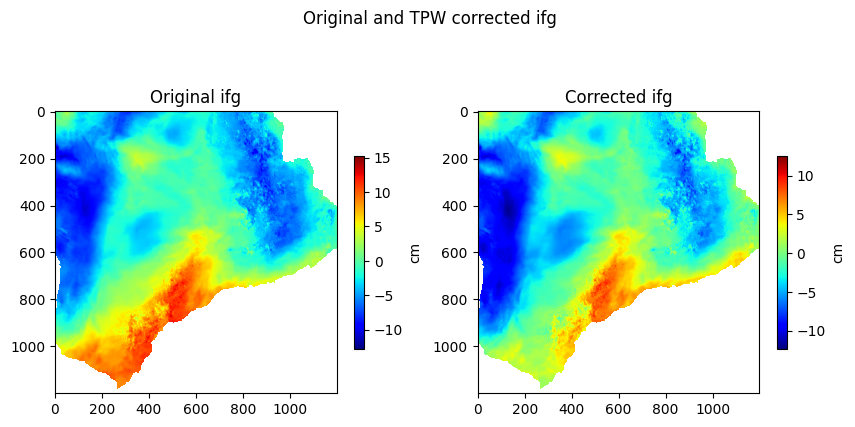

In [134]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow((ifg - ifg[500,800]), cmap='jet')
im2 = ax[1].imshow((ifg - ifg[500,800]) - (TPW_ - TPW_[500,800]) - (HTD - HTD[500,800])*100, cmap='jet')
ax[0].title.set_text('Original ifg')
ax[1].title.set_text('Corrected ifg')
plt.colorbar(im1, ax=ax[0], shrink=.5, pad=.05, label='cm')
plt.colorbar(im2, ax=ax[1], shrink=.5, pad=.05, label='cm')
fig.suptitle('Original and TPW corrected ifg')
plt.show()

In [135]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[500, 800])
# TPW corrected ifg std
TPW_corr_std = np.nanstd(ifg - ifg[500, 800] - ((TPW_ - TPW_[500, 800])) - (HTD - HTD[500,800])*100)
# Percentage chage
per_change = (TPW_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('TPW corrected ifg std: ', TPW_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  4.926694
TPW corrected ifg std:  3.993045351671877
Percentage change:  -0.18950813273704692


## RAiDER correction

In [108]:
# dem = 'InSAR/Large_scale/West/Extracted/DEM/SRTM_3arcsec_uncropped.tif'
wm1 = 'InSAR/Hawaii/weather_model/weather_files/ERA-5_2019_11_17_T04_00_00_15N_26N_162W_150W.nc'
wm2 = 'InSAR/Hawaii/weather_model/weather_files/ERA-5_2019_11_23_T04_00_00_15N_26N_162W_150W.nc'
WM1 = xr.load_dataset(wm1)
WM2 = xr.load_dataset(wm2)
# DEM, grid = Resamp_rasterio(dem, left=-120.561666666666, bottom=38.4916666666667, right=-117.044166666666, top=41.3408333333333, ref=ifg)

In [114]:
loc = np.hstack((grid, DEM.ravel().reshape(-1,1)))

In [115]:
hydro_interp_1, wet_interp_1, hydro_interp_2, wet_interp_2 = make_interpretor(WM1, 'hydro_total'), make_interpretor(WM1, 'wet_total'), make_interpretor(WM2, 'hydro_total'), make_interpretor(WM2, 'wet_total')
hydro_1, wet_1, hydro_2, wet_2 = hydro_interp_1(loc), wet_interp_1(loc), hydro_interp_2(loc), wet_interp_2(loc)
TD = (hydro_1 + wet_1) - (hydro_2 + wet_2)
HTD = hydro_1-hydro_2
TD = TD.reshape(DEM.shape)
HTD = HTD.reshape(DEM.shape)

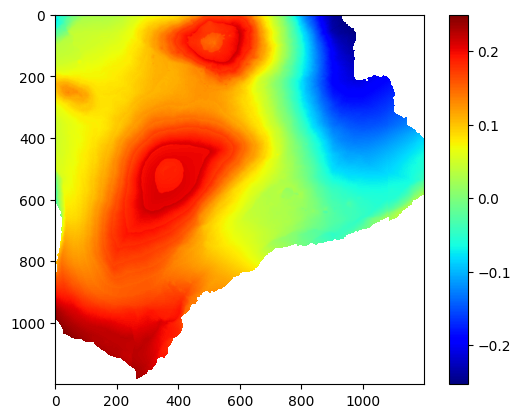

In [127]:
plt.imshow((HTD - HTD[500,800])*100, cmap='jet')
plt.colorbar()
plt.show()

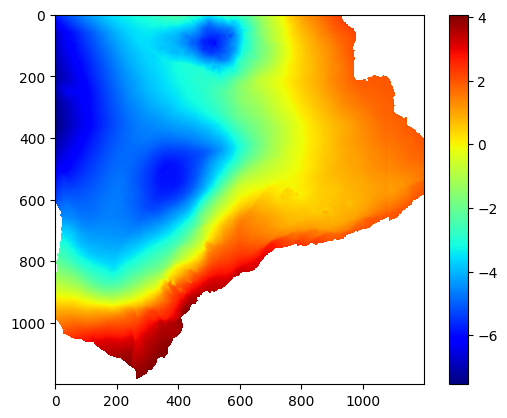

In [131]:
plt.imshow((TD - TD[500,800])*100, cmap='jet')
plt.colorbar()
plt.show()

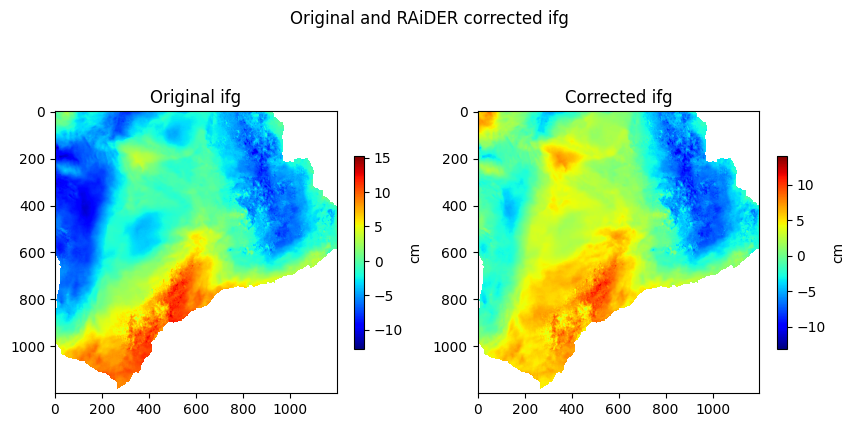

In [132]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow((ifg - ifg[500,800]), cmap='jet')
im2 = ax[1].imshow((ifg - ifg[500,800]) - (TD - TD[500,800])*100, cmap='jet')
ax[0].title.set_text('Original ifg')
ax[1].title.set_text('Corrected ifg')
plt.colorbar(im1, ax=ax[0], shrink=.5, pad=.05, label='cm')
plt.colorbar(im2, ax=ax[1], shrink=.5, pad=.05, label='cm')
fig.suptitle('Original and RAiDER corrected ifg')
plt.show()

In [133]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[500, 800])
# TPW corrected ifg std
TPW_corr_std = np.nanstd(ifg - ifg[500, 800]- (TD - TD[500,800])*100)
# Percentage chage
per_change = (TPW_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('TPW corrected ifg std: ', TPW_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  4.926694
TPW corrected ifg std:  4.20500354413395
Percentage change:  -0.14648573352529295
